# Neutrino MC Analysis

Exploring feasibility of mixed muon-neutrino MC simulation

In [1]:
import ROOT
import numpy as np
import awkward as ak
import uproot
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from matplotlib import colors
import scipy as sp
from scipy import stats
from particle import Particle
import pandas
import sys
sys.path.insert(1, './emu_reco_analysis/scipy_conversion/') #adding the path to the import
import fedra2scipy_utils as fedra2scipy
import pickle as pkl

Welcome to JupyROOT 6.26/10
Load FEDRA libs


In [223]:
!ls /eos/user/a/aiulian/sim_fedra/nu_sim_activeemu_withcrisfiles_25_July_2022/b000011

b000011.0.0.0.set.root	p007  p016  p025  p034	p043  p052  scanset.sh
b000011.0.0.0.trk.root	p008  p017  p026  p035	p044  p053  track.rootrc
linked_tracks.root	p009  p018  p027  p036	p045  p054  track.save.rootrc
p001			p010  p019  p028  p037	p046  p055  vertexing.C
p002			p011  p020  p029  p038	p047  p056  vertextree.root
p003			p012  p021  p030  p039	p048  p057
p004			p013  p022  p031  p040	p049  p058
p005			p014  p023  p032  p041	p050  p059
p006			p015  p024  p033  p042	p051  p060


#### Start with the tracks file

In [2]:
input_file = uproot.open("/eos/user/a/aiulian/sim_fedra/nu_sim_activeemu_withcrisfiles_25_July_2022/b000011/b000011.0.0.0.trk.root")
input_tree = input_file['tracks']


In [3]:
input_tree.keys()

['trid',
 'nseg',
 'npl',
 'n0',
 'xv',
 'yv',
 'w',
 't.',
 's',
 's/s.fUniqueID',
 's/s.fBits',
 's/s.EdbTrack2D',
 's/s.ePID',
 's/s.eID',
 's/s.eVid[2]',
 's/s.eAid[2]',
 's/s.eFlag',
 's/s.eTrack',
 's/s.eX',
 's/s.eY',
 's/s.eZ',
 's/s.eTX',
 's/s.eTY',
 's/s.eSZ',
 's/s.eChi2',
 's/s.eProb',
 's/s.eW',
 's/s.eVolume',
 's/s.eDZ',
 's/s.eDZem',
 's/s.eP',
 's/s.eMCTrack',
 's/s.eMCEvt',
 's/s.eScanID',
 's/s.eCOV',
 'sf',
 'sf/sf.fUniqueID',
 'sf/sf.fBits',
 'sf/sf.EdbTrack2D',
 'sf/sf.ePID',
 'sf/sf.eID',
 'sf/sf.eVid[2]',
 'sf/sf.eAid[2]',
 'sf/sf.eFlag',
 'sf/sf.eTrack',
 'sf/sf.eX',
 'sf/sf.eY',
 'sf/sf.eZ',
 'sf/sf.eTX',
 'sf/sf.eTY',
 'sf/sf.eSZ',
 'sf/sf.eChi2',
 'sf/sf.eProb',
 'sf/sf.eW',
 'sf/sf.eVolume',
 'sf/sf.eDZ',
 'sf/sf.eDZem',
 'sf/sf.eP',
 'sf/sf.eMCTrack',
 'sf/sf.eMCEvt',
 'sf/sf.eScanID',
 'sf/sf.eCOV']

In [4]:
branchnames = ["trid", "nseg", "npl", "n0", "s/s.eTX", "s/s.eTY", "sf/sf.eTX", "sf/sf.eTY", "s/s.fUniqueID", "s/s.eVid[2]", "s/s.ePID", "s/s.eMCTrack", "s/s.eMCEvt"]
segments = input_tree.arrays(branchnames)


The tracks file is grouped in tracks, with segments/base tracks as the elements

#### This file doesn't have Mother ID, so I'll use the vertex file which does

In [6]:
# use the vertex file to get the mother ID
vtx_file = uproot.open("/eos/user/a/aiulian/sim_fedra/nu_sim_activeemu_withcrisfiles_25_July_2022/b000011/vertextree.root")
vtx_tree = vtx_file['vtx']


In [7]:
# vertices in all bricks
totalv_file = uproot.open("/eos/user/a/aiulian/sim_fedra/nu_sim_activeemu_withcrisfiles_25_July_2022/vertextree.root")
totalv_tree = totalv_file['vtx']


In [8]:
totalv_tree.keys()

['vID',
 'flag',
 'vx',
 'vy',
 'vz',
 'vCOV',
 'meanvx',
 'meanvy',
 'meanvz',
 'maxaperture',
 'probability',
 'n',
 't.',
 't./t.fUniqueID',
 't./t.fBits',
 't./t.EdbTrack2D',
 't./t.ePID',
 't./t.eID',
 't./t.eVid[2]',
 't./t.eAid[2]',
 't./t.eFlag',
 't./t.eTrack',
 't./t.eX',
 't./t.eY',
 't./t.eZ',
 't./t.eTX',
 't./t.eTY',
 't./t.eSZ',
 't./t.eChi2',
 't./t.eProb',
 't./t.eW',
 't./t.eVolume',
 't./t.eDZ',
 't./t.eDZem',
 't./t.eP',
 't./t.eMCTrack',
 't./t.eMCEvt',
 't./t.eScanID',
 't./t.eCOV',
 's',
 's/s.fUniqueID',
 's/s.fBits',
 's/s.EdbTrack2D',
 's/s.ePID',
 's/s.eID',
 's/s.eVid[2]',
 's/s.eAid[2]',
 's/s.eFlag',
 's/s.eTrack',
 's/s.eX',
 's/s.eY',
 's/s.eZ',
 's/s.eTX',
 's/s.eTY',
 's/s.eSZ',
 's/s.eChi2',
 's/s.eProb',
 's/s.eW',
 's/s.eVolume',
 's/s.eDZ',
 's/s.eDZem',
 's/s.eP',
 's/s.eMCTrack',
 's/s.eMCEvt',
 's/s.eScanID',
 's/s.eCOV',
 'sf',
 'sf/sf.fUniqueID',
 'sf/sf.fBits',
 'sf/sf.EdbTrack2D',
 'sf/sf.ePID',
 'sf/sf.eID',
 'sf/sf.eVid[2]',
 'sf/sf.eAid[2

In [47]:
branchnames = ["s/s.eTX", "s/s.eTY", "sf/sf.eTX", "sf/sf.eTY", "s/s.fUniqueID", "s/s.eVid[2]", "s/s.ePID", "s/s.eMCTrack", "s/s.eMCEvt", "MCMotherID", "MCTrackID", "MCEventID","MCTrackPdgCode", "vx", "vy", "vz", "nseg", "npl", "nholes", "maxgap", "impactparameter", "flag", "probability", "maxaperture", "n", "meanvx", "meanvy", "meanvz"]
vtx = vtx_tree.arrays(branchnames)


The vertex file is grouped in vertices, with reconstructed volume tracks as the elements

#### Get Charge Information

In [ ]:
# this creates a dictionary linking pdg code to charge
charge = dict([(Particle.findall()[i].pdgid, Particle.findall()[i].charge) for i in range((6496))])

In [394]:
trackpdgs = vtx["MCTrackPdgCode"]
trackcharge = []
for eventi in range(len(trackpdgs)):
    if len(trackpdgs[eventi])>0:
        trackcharge.append(np.vectorize(charge.get)(trackpdgs[eventi]))
    else:
        trackcharge.append([])
awtrackcharge = ak.Array(trackcharge)
#adding track branch
vtx["s/s.fCharge"] = awtrackcharge

In [212]:
pdg_vals = [[j[0] for j in i] for i in segments["s/s.eVid[2]"]] # should be pdg code
ak_pdg_vals = ak.Array(pdg_vals)
segments['s/s.pdg_id'] = ak_pdg_vals

In [213]:
trackpdgs = segments["s/s.pdg_id"]
trackcharge = []
for eventi in range(len(trackpdgs)):
    if len(trackpdgs[eventi])>0:
        trackcharge.append(np.vectorize(charge.get)(trackpdgs[eventi]))
    else:
        trackcharge.append([])
awtrackcharge = ak.Array(trackcharge)
#adding track branch
segments["s/s.fCharge"] = awtrackcharge

#### Apply Position and Angular Selections using the Vertex file

Problem: how to check that interaction is within target?
- we didn't end up doing that check!

In [16]:
seltracks = vtx

There are no neutrinos, but that makes sense since you can't see the neutrinos or other neutral particles in the emulsion, and this is emulsion data!

Next we separate the neutrino daughters from the other particles, and get the base track angles

In [17]:
# all of the tracks are already charged...
daughters = (np.abs(seltracks["MCMotherID"]) == 0)  # neutrino daughter cut
others = (np.abs(seltracks["MCMotherID"]) > 0) # other particle cut

In [18]:
# neutrino daughters
ds_xangle = ak.to_numpy(ak.flatten(seltracks['s/s.eTX', daughters]))
ds_yangle = ak.to_numpy(ak.flatten(seltracks['s/s.eTY', daughters]))
dsf_xangle = ak.to_numpy(ak.flatten(seltracks['sf/sf.eTX', daughters]))
dsf_yangle = ak.to_numpy(ak.flatten(seltracks['sf/sf.eTY', daughters]))

In [19]:
# other particles
os_xangle = ak.to_numpy(ak.flatten(seltracks['s/s.eTX', others]))
os_yangle = ak.to_numpy(ak.flatten(seltracks['s/s.eTY', others]))
osf_xangle = ak.to_numpy(ak.flatten(seltracks['sf/sf.eTX', others]))
osf_yangle = ak.to_numpy(ak.flatten(seltracks['sf/sf.eTY', others]))

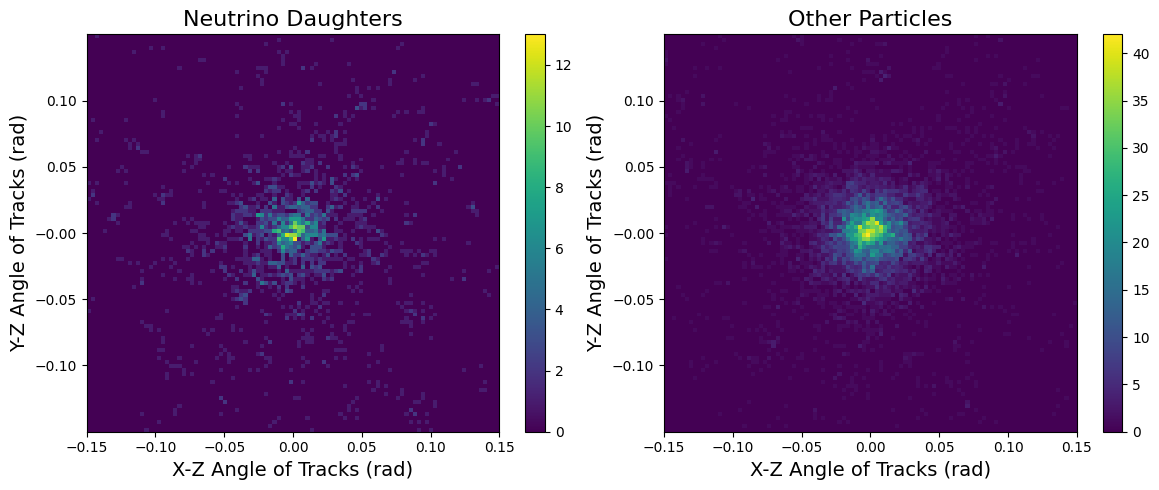

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)
thres = 0.15
range_=((-1*thres, thres), (-1*thres, thres))
hist1 = ax[0].hist2d(ds_xangle, ds_yangle, bins=100, range=range_) # the first track is always the neutrino
ax[0].set_xlabel("X-Z Angle of Tracks (rad)", fontsize=14)
ax[0].set_ylabel("Y-Z Angle of Tracks (rad)", fontsize=14)
ax[0].set_title("Neutrino Daughters", fontsize=16)
hist2 = ax[1].hist2d(os_xangle, os_yangle, bins=100, range=range_) # the first track is always the neutrino
ax[1].set_xlabel("X-Z Angle of Tracks (rad)", fontsize=14)
ax[1].set_ylabel("Y-Z Angle of Tracks (rad)", fontsize=14)
ax[1].set_title("Other Particles", fontsize=16)
ax[0].set_yticks(np.arange(-0.1, 0.1, 0.04999))
ax[1].set_yticks(np.arange(-0.1, 0.1, 0.04999))
fig.colorbar(hist1[3], ax=ax[0])
fig.colorbar(hist2[3], ax=ax[1])
fig.tight_layout()
plt.grid(False)
plt.savefig("Figures/NeutrinoSim/AngularDist_2dHist_Emulsion.pdf")
plt.show()

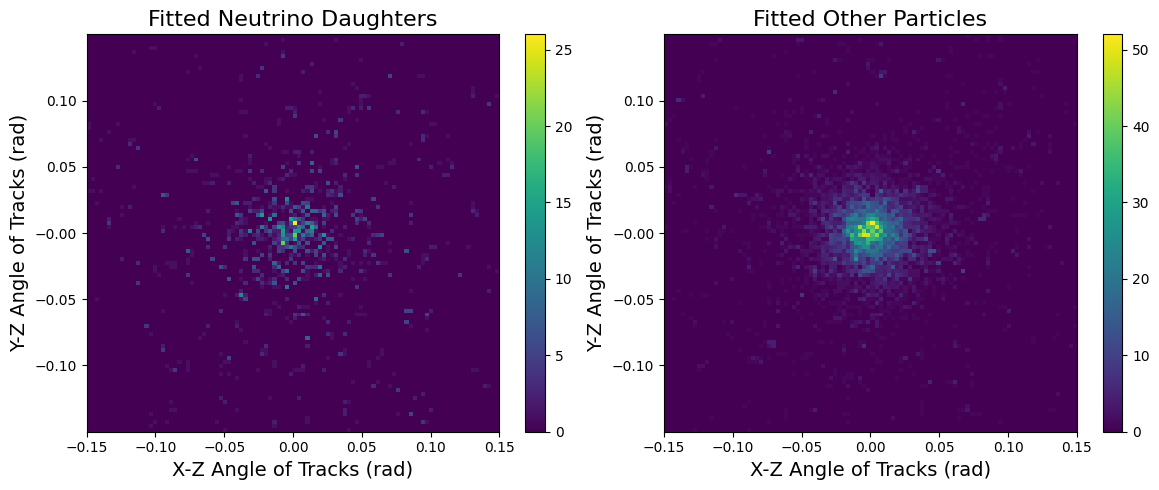

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)
thres = 0.15
range_=((-1*thres, thres), (-1*thres, thres))
hist1 = ax[0].hist2d(dsf_xangle, dsf_yangle, bins=100, range=range_) # the first track is always the neutrino
ax[0].set_xlabel("X-Z Angle of Tracks (rad)", fontsize=14)
ax[0].set_ylabel("Y-Z Angle of Tracks (rad)", fontsize=14)
ax[0].set_title("Fitted Neutrino Daughters", fontsize=16)
hist2 = ax[1].hist2d(osf_xangle, osf_yangle, bins=100, range=range_) # the first track is always the neutrino
ax[1].set_xlabel("X-Z Angle of Tracks (rad)", fontsize=14)
ax[1].set_ylabel("Y-Z Angle of Tracks (rad)", fontsize=14)
ax[1].set_title("Fitted Other Particles", fontsize=16)
ax[0].set_yticks(np.arange(-0.1, 0.1, 0.04999))
ax[1].set_yticks(np.arange(-0.1, 0.1, 0.04999))
fig.colorbar(hist1[3], ax=ax[0])
fig.colorbar(hist2[3], ax=ax[1])
fig.tight_layout()
plt.grid(False)
plt.savefig("Figures/NeutrinoSim/AngularDist_2dHist_Emulsion_Fitted.pdf")
plt.show()

Neutrino daughters overall seem more diffuse than other particles, but that could be an artifact due to the difference in statistics. Let's see the actual distribution:

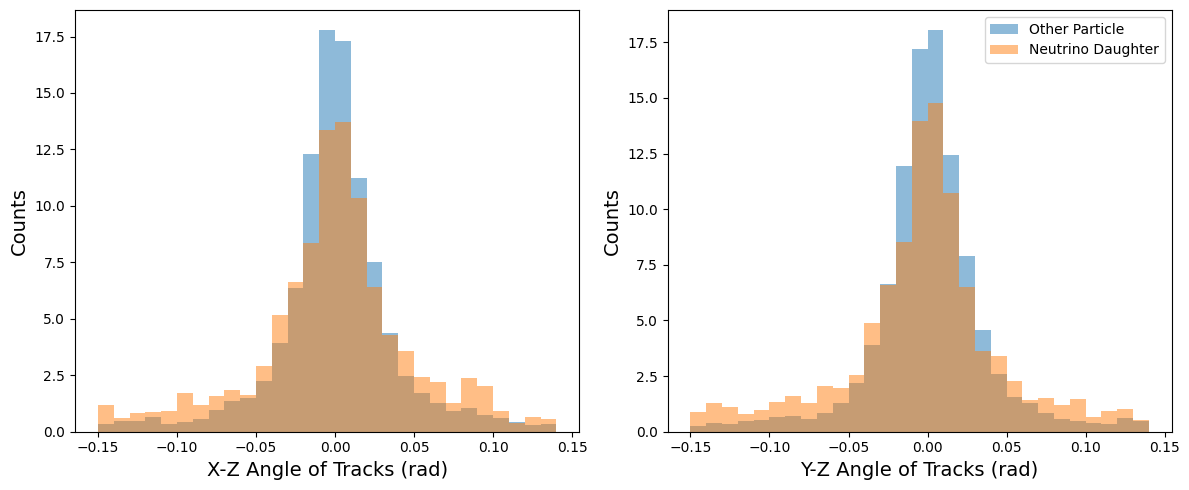

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)
thres = 0.15
range_=((-1*thres, thres), (-1*thres, thres))
ax[0].hist(os_xangle, bins=np.arange(-1*thres, thres, 0.01), density=True, alpha=0.5) 
ax[0].hist(ds_xangle, bins=np.arange(-1*thres, thres, 0.01), density=True, alpha=0.5) 
ax[0].set_xlabel("X-Z Angle of Tracks (rad)", fontsize=14)
ax[0].set_ylabel("Counts", fontsize=14)
ax[1].hist(os_yangle, bins=np.arange(-1*thres, thres, 0.01), density=True, alpha=0.5, label="Other Particle") 
ax[1].hist(ds_yangle, bins=np.arange(-1*thres, thres, 0.01), density=True, alpha=0.5, label="Neutrino Daughter") 
ax[1].set_xlabel("Y-Z Angle of Tracks (rad)", fontsize=14)
ax[1].set_ylabel("Counts", fontsize=14)

ax[1].legend()
fig.tight_layout()
plt.grid(False)
plt.savefig("Figures/NeutrinoSim/AngularDist_1dHist_norm_Emulsion.pdf")
plt.show()

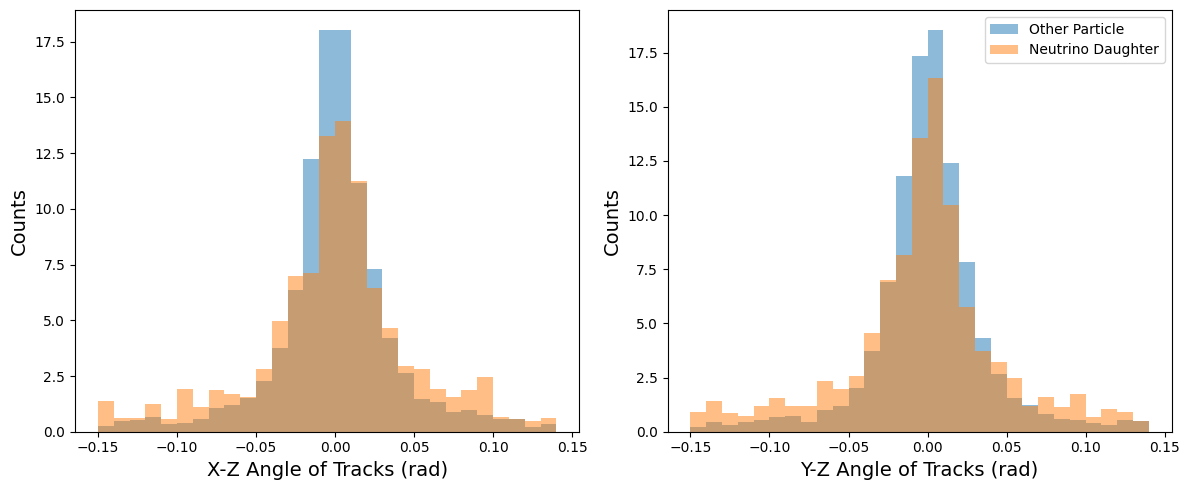

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)
thres = 0.15
range_=((-1*thres, thres), (-1*thres, thres))
ax[0].hist(osf_xangle, bins=np.arange(-1*thres, thres, 0.01), density=True, alpha=0.5) 
ax[0].hist(dsf_xangle, bins=np.arange(-1*thres, thres, 0.01), density=True, alpha=0.5) 
ax[0].set_xlabel("X-Z Angle of Tracks (rad)", fontsize=14)
ax[0].set_ylabel("Counts", fontsize=14)
ax[1].hist(osf_yangle, bins=np.arange(-1*thres, thres, 0.01), density=True, alpha=0.5, label="Other Particle") 
ax[1].hist(dsf_yangle, bins=np.arange(-1*thres, thres, 0.01), density=True, alpha=0.5, label="Neutrino Daughter") 
ax[1].set_xlabel("Y-Z Angle of Tracks (rad)", fontsize=14)
ax[1].set_ylabel("Counts", fontsize=14)

ax[1].legend()
fig.tight_layout()
plt.grid(False)
plt.savefig("Figures/NeutrinoSim/AngularDist_1dHist_norm_Emulsion_Fitted.pdf")
plt.show()

From this, it seems that angular cuts for more extreme values would result in larger concentrations of neutrino daughters, but would also result in cutting the bulk of the sample. So, there's a tradeoff if we want to impose a cutoff

#### Recognizing Vertices from Neutrino Interactions (still using the Vertex file)

Vertex keys:

"nseg", "npl", "nholes", "s/s.eTX", "s/s.eTY", "sf/sf.eTX", "sf/sf.eTY", "s/s.fUniqueID", "s/s.eVid[2]", "s/s.ePID", "s/s.eMCTrack", "s/s.eMCEvt", "MCMotherID", "vx", "vy", "vz", "nseg", "npl", "nholes", "maxgap", "impactparameter", "flag", "probability", "maxaperture", "n", "meanvx", "meanvy", "meanvz"


In [24]:
neutrino_vertices = [evt for evt in seltracks if all(evt['MCMotherID']==0)]
other_vertices = [evt for evt in seltracks if not all(evt['MCMotherID']==0)]

In [25]:
var = 'probability'
dau_res = [evt[var] for evt in neutrino_vertices]
oth_res = [evt[var] for evt in other_vertices]

Note: Here, I'm assuming that if a vertex has only neutrino daughters, it is a neutrino vertex. Also, I'm assuming probability is probability of being a neutrino event.

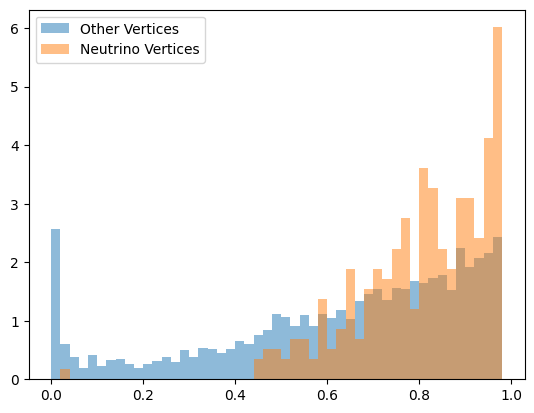

In [30]:
fig, ax = plt.subplots()
ax.hist(oth_res, alpha=0.5, bins=np.arange(0, 1, 0.02), density=True, label="Other Vertices")
ax.hist(dau_res, alpha=0.5, bins=np.arange(0, 1, 0.02), density=True, label="Neutrino Vertices")
ax.legend()
plt.savefig("Figures/NeutrinoSim/NeutrinoVertexSim_1dHist_norm_prob.pdf")
plt.show()

Observations:
- Probability of Neutrino vertices is higher than other vertices (makes sense if it's probability of neutrino vertex though)
- Neutrino vertices are more of flags 1&4, similar/slightly less 0&3, and much less 2&5
- Neutrino vertices have on average larger maxaperture
- Neutrino vertices have fewer n=3 tracks - that's weird, why is that?
- Neutrino Vertices have a different mean vz distribution - more large negative values and less small (close to 0) values

#### Computing Vertex Reconstruction Efficiency

First, get the true simulation file to get the simulated neutrino daughter events

In [9]:
totalv_file = uproot.open("/eos/user/a/aiulian/sim_fedra/nu_sim_activeemu_withcrisfiles_25_July_2022/vertextree.root")
totalv_tree = totalv_file['vtx']

In [10]:
totalv_tree.keys()

['vID',
 'flag',
 'vx',
 'vy',
 'vz',
 'vCOV',
 'meanvx',
 'meanvy',
 'meanvz',
 'maxaperture',
 'probability',
 'n',
 't.',
 't./t.fUniqueID',
 't./t.fBits',
 't./t.EdbTrack2D',
 't./t.ePID',
 't./t.eID',
 't./t.eVid[2]',
 't./t.eAid[2]',
 't./t.eFlag',
 't./t.eTrack',
 't./t.eX',
 't./t.eY',
 't./t.eZ',
 't./t.eTX',
 't./t.eTY',
 't./t.eSZ',
 't./t.eChi2',
 't./t.eProb',
 't./t.eW',
 't./t.eVolume',
 't./t.eDZ',
 't./t.eDZem',
 't./t.eP',
 't./t.eMCTrack',
 't./t.eMCEvt',
 't./t.eScanID',
 't./t.eCOV',
 's',
 's/s.fUniqueID',
 's/s.fBits',
 's/s.EdbTrack2D',
 's/s.ePID',
 's/s.eID',
 's/s.eVid[2]',
 's/s.eAid[2]',
 's/s.eFlag',
 's/s.eTrack',
 's/s.eX',
 's/s.eY',
 's/s.eZ',
 's/s.eTX',
 's/s.eTY',
 's/s.eSZ',
 's/s.eChi2',
 's/s.eProb',
 's/s.eW',
 's/s.eVolume',
 's/s.eDZ',
 's/s.eDZem',
 's/s.eP',
 's/s.eMCTrack',
 's/s.eMCEvt',
 's/s.eScanID',
 's/s.eCOV',
 'sf',
 'sf/sf.fUniqueID',
 'sf/sf.fBits',
 'sf/sf.EdbTrack2D',
 'sf/sf.ePID',
 'sf/sf.eID',
 'sf/sf.eVid[2]',
 'sf/sf.eAid[2

In [11]:
branchnames = ["s/s.eTX", "s/s.eTY", "sf/sf.eTX", "sf/sf.eTY", "s/s.fUniqueID", "s/s.eVid[2]", "s/s.ePID", "s/s.eMCTrack", "s/s.eMCEvt", "MCMotherID", "MCTrackID", "MCEventID","MCTrackPdgCode", "vx", "vy", "vz", "nseg", "npl", "nholes", "maxgap", "impactparameter", "flag", "probability", "maxaperture", "n", "meanvx", "meanvy", "meanvz", 's/s.eX', 's/s.eY', 's/s.eZ']
total_vtx = totalv_tree.arrays(branchnames)


## Getting position of hits wrt vertex (within a single brick)

This tells us whether we might be able to simulate a smaller sample of mixed neutrino/muon interactions to compare the two

In [2]:
truesim_file = uproot.open("/eos/experiment/sndlhc/MonteCarlo/Neutrinos/Genie/nu_sim_activeemu_withcrisfiles_25_July_2022/sndLHC.Genie-TGeant4.root")
truesim_tree = truesim_file['cbmsim']

In [3]:
truesim_tree.keys()

['MCTrack',
 'MCTrack/MCTrack.fUniqueID',
 'MCTrack/MCTrack.fBits',
 'MCTrack/MCTrack.fPdgCode',
 'MCTrack/MCTrack.fMotherId',
 'MCTrack/MCTrack.fPx',
 'MCTrack/MCTrack.fPy',
 'MCTrack/MCTrack.fPz',
 'MCTrack/MCTrack.fM',
 'MCTrack/MCTrack.fStartX',
 'MCTrack/MCTrack.fStartY',
 'MCTrack/MCTrack.fStartZ',
 'MCTrack/MCTrack.fStartT',
 'MCTrack/MCTrack.fW',
 'MCTrack/MCTrack.fProcID',
 'MCTrack/MCTrack.fNPoints',
 'vetoPoint',
 'vetoPoint/vetoPoint.fUniqueID',
 'vetoPoint/vetoPoint.fBits',
 'vetoPoint/vetoPoint.fLink',
 'vetoPoint/vetoPoint.fTrackID',
 'vetoPoint/vetoPoint.fEventId',
 'vetoPoint/vetoPoint.fPx',
 'vetoPoint/vetoPoint.fPy',
 'vetoPoint/vetoPoint.fPz',
 'vetoPoint/vetoPoint.fTime',
 'vetoPoint/vetoPoint.fLength',
 'vetoPoint/vetoPoint.fELoss',
 'vetoPoint/vetoPoint.fDetectorID',
 'vetoPoint/vetoPoint.fX',
 'vetoPoint/vetoPoint.fY',
 'vetoPoint/vetoPoint.fZ',
 'vetoPoint/vetoPoint.fPdgCode',
 'vetoPoint/vetoPoint.fLpos',
 'vetoPoint/vetoPoint.fLmom',
 'EmulsionDetPoint',
 'Em

In [5]:
def FindBrick(hitX, hitY, hitZ):
    xborder = -27.5 # arbitrary, but accurate enough to separate the bricks
    yborder = 35.1
    # nx, ny, nz;
    if (hitX > xborder):
        nx = 0 # left 1, right 0, x positive towards right
    else:
        nx = 1
    if (hitY < yborder): 
        ny = 0 # down 0, up 1, y positive towards up
    else:
        ny = 1

    # beam exiting
    z0_start = 290.7368
    z0_end = 298.8862
    z1_start = 303.7358
    z1_end = 311.8852
    z2_start = 316.7348
    z2_end = 324.8842
    z3_start = 329.7338
    z3_end = 337.8832
    z4_start = 342.7328
    z4_end = 350.8822

    if (hitZ > z0_start and hitZ < z0_end): 
        nz = 1
    elif(hitZ > z1_start and hitZ < z1_end):
        nz = 2
    elif(hitZ > z2_start and hitZ < z2_end):
        nz = 3
    elif(hitZ > z3_start and hitZ < z3_end):
        nz = 4
    elif(hitZ > z4_start and hitZ < z4_end):
        nz = 5
    else:
        nz = -10 # not in a brick

    nbrick = nx + ny*2 + 10 * nz
    return nbrick+1
# possible numbers: 11, 12, 13, 14, 21,22,23,24, 31,32,33,34, 41,42,43,44, 50,51,52,53,54//

In [6]:
def getHits(x, y, z, v_x, v_y, v_z):
    if FindBrick(x, y, z)==FindBrick(v_x, v_y, v_z):
        return (x-v_x, y-v_y, z-v_z, getDepth(v_z)) # added z pos of vertex to tell where it is in the brick
    else:
        return (None, None, None, None)
    
def getDepth(hitZ):
    # beam exiting
    z0_start = 290.7368
    z0_end = 298.8862
    z1_start = 303.7358
    z1_end = 311.8852
    z2_start = 316.7348
    z2_end = 324.8842
    z3_start = 329.7338
    z3_end = 337.8832
    z4_start = 342.7328
    z4_end = 350.8822

    if (hitZ > z0_start and hitZ < z0_end): 
        return hitZ - z0_start
    elif(hitZ > z1_start and hitZ < z1_end):
        return hitZ - z1_start
    elif(hitZ > z2_start and hitZ < z2_end):
        return hitZ - z2_start
    elif(hitZ > z3_start and hitZ < z3_end):
        return hitZ - z3_start
    elif(hitZ > z4_start and hitZ < z4_end):
        return hitZ - z4_start
    else:
        return -1


In [7]:
x_rel = []
y_rel = []
z_rel = []
z_vtx = []
x_angle = []
y_angle = []

branchnames = ["MCTrack/MCTrack.fStartX", "MCTrack/MCTrack.fStartY", "MCTrack/MCTrack.fStartZ", "MCTrack/MCTrack.fMotherId", "EmulsionDetPoint/EmulsionDetPoint.fX", "EmulsionDetPoint/EmulsionDetPoint.fY", "EmulsionDetPoint/EmulsionDetPoint.fZ", "EmulsionDetPoint/EmulsionDetPoint.fTrackID", "EmulsionDetPoint/EmulsionDetPoint.fPx", "EmulsionDetPoint/EmulsionDetPoint.fPy", "EmulsionDetPoint/EmulsionDetPoint.fPz"]
# truesim = truesim_tree.arrays(branchnames, entry_start = 0, entry_stop = 1000)
for truesim in truesim_tree.iterate(branchnames, step_size=500):
    truesim['MCTrack/MCTrack.fTrackID'] = [range(1, len(truesim['MCTrack/MCTrack.fStartX'][i])+1) for i in range(len(truesim['MCTrack/MCTrack.fStartX']))]
    for e in range(len(truesim['MCTrack/MCTrack.fTrackID'])): # this is the event number
        for t in range(len(truesim['EmulsionDetPoint/EmulsionDetPoint.fTrackID'][e])): # this is the track number
            tracknum = truesim['EmulsionDetPoint/EmulsionDetPoint.fTrackID'][e][t]
            if tracknum>=0 and truesim['MCTrack/MCTrack.fMotherId'][e][tracknum-1]==0:
                x = truesim['EmulsionDetPoint/EmulsionDetPoint.fX'][e][t] 
                y = truesim['EmulsionDetPoint/EmulsionDetPoint.fY'][e][t]
                z = truesim['EmulsionDetPoint/EmulsionDetPoint.fZ'][e][t] 
                # find the track with the same track number

                v_x = truesim['MCTrack/MCTrack.fStartX'][e][tracknum-1]
                v_y = truesim['MCTrack/MCTrack.fStartY'][e][tracknum-1]
                v_z = truesim['MCTrack/MCTrack.fStartZ'][e][tracknum-1]
                x_new, y_new, z_new, z_vtxnew = getHits(x, y, z, v_x, v_y, v_z)

                if x_new!=None:
                    x_angle += [np.arctan2(truesim['EmulsionDetPoint/EmulsionDetPoint.fPx'][e][t], truesim['EmulsionDetPoint/EmulsionDetPoint.fPz'][e][t])]
                    y_angle += [np.arctan2(truesim['EmulsionDetPoint/EmulsionDetPoint.fPy'][e][t], truesim['EmulsionDetPoint/EmulsionDetPoint.fPz'][e][t])]
                    x_rel += [x_new]
                    y_rel += [y_new]
                    z_rel += [z_new]
                    z_vtx += [z_vtxnew] # how far (along z) into the brick the vertex is located
            else:
                break
        print(e)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443


355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
13

38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
30

In [10]:
len(x_rel)

51176

In [64]:
len(ak.flatten(truesim_tree.arrays(['EmulsionDetPoint/EmulsionDetPoint.fX'])['EmulsionDetPoint/EmulsionDetPoint.fX']))

597855888

Now we can plot the positions of the base tracks with respect to the vertex!

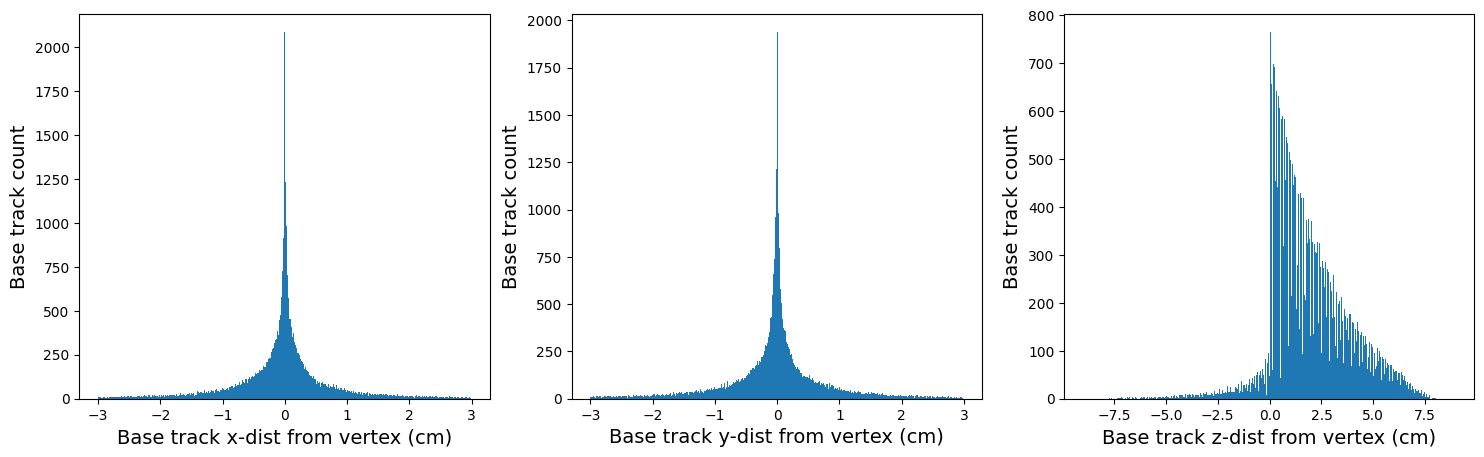

In [65]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].hist(np.asarray(x_rel), bins=np.arange(-3, 3, 0.01))
ax[1].hist(np.asarray(y_rel), bins=np.arange(-3, 3, 0.01))
ax[2].hist(np.asarray(z_rel), bins=np.arange(-9, 9, 0.03))
ax[0].set_xlabel("Base track x-dist from vertex (cm)", fontsize=14)
ax[1].set_xlabel("Base track y-dist from vertex (cm)", fontsize=14)
ax[2].set_xlabel("Base track z-dist from vertex (cm)", fontsize=14)
ax[0].set_ylabel("Base track count", fontsize=14)
ax[1].set_ylabel("Base track count", fontsize=14)
ax[2].set_ylabel("Base track count", fontsize=14)
ax[2].ticklabel_format(style='sci', scilimits=(0, 3))
plt.savefig("Figures/NeutrinoSim/NeutrinoVertexSim_1dHist_BaseTrackVtxDist.pdf")
plt.show()

We can also look at it in 2d, with linear or log scaling:

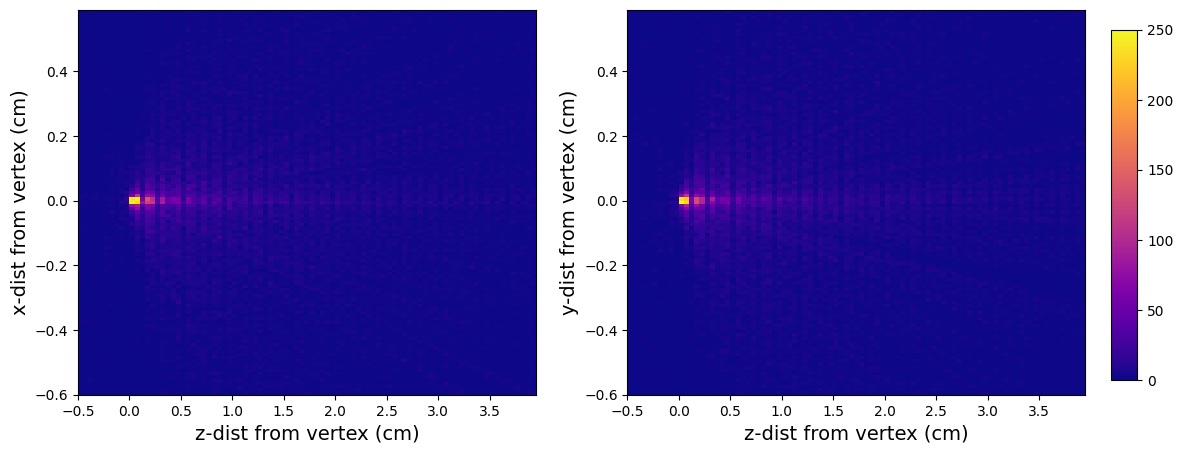

In [123]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
hist1 = ax[0].hist2d(np.asarray(z_rel), np.asarray(x_rel), bins=[np.arange(-0.5, 4, 0.05), np.arange(-0.6, 0.6, 0.01)], vmin=0, vmax=250, cmap=mpl.colormaps['plasma'])
hist2 = ax[1].hist2d(np.asarray(z_rel), np.asarray(y_rel), bins=[np.arange(-0.5, 4, 0.05), np.arange(-0.6, 0.6, 0.01)],vmin=0, vmax=250, cmap=mpl.colormaps['plasma'])
ax[0].set_xlabel("z-dist from vertex (cm)", fontsize=14)
ax[1].set_xlabel("z-dist from vertex (cm)", fontsize=14)
ax[0].set_ylabel("x-dist from vertex (cm)", fontsize=14)
ax[1].set_ylabel("y-dist from vertex (cm)", fontsize=14)
cbar_ax = fig.add_axes([0.92, 0.14, 0.02, 0.7])
fig.colorbar(hist2[3], cax=cbar_ax)
#plt.savefig("Figures/NeutrinoSim/NeutrinoVertexSim_2dHist_BaseTrackVtxDist.pdf")
plt.show()

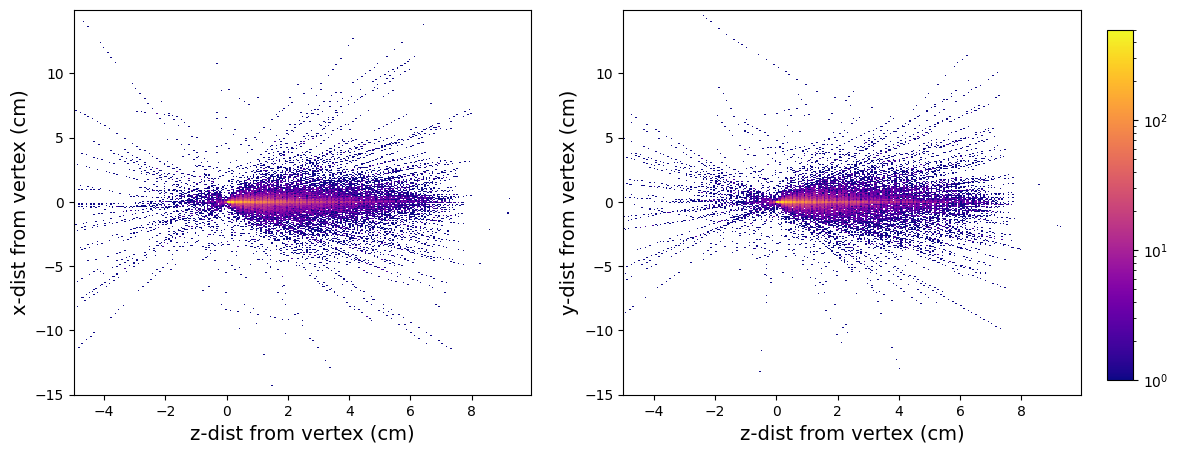

In [181]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
# bins=[np.arange(-1, 15, 0.05), np.arange(-5, 5, 0.05)]
hist1 = ax[0].hist2d(np.asarray(z_rel), np.asarray(x_rel), bins=[np.arange(-5, 10, 0.05), np.arange(-15, 15, 0.05)], cmap=mpl.colormaps['plasma'], norm=colors.LogNorm(vmin=1, vmax=500))
hist2 = ax[1].hist2d(np.asarray(z_rel), np.asarray(y_rel), bins=[np.arange(-5, 10, 0.05), np.arange(-15, 15, 0.05)], cmap=mpl.colormaps['plasma'], norm=colors.LogNorm(vmin=1, vmax=500))
ax[0].set_xlabel("z-dist from vertex (cm)", fontsize=14)
ax[1].set_xlabel("z-dist from vertex (cm)", fontsize=14)
ax[0].set_ylabel("x-dist from vertex (cm)", fontsize=14)
ax[1].set_ylabel("y-dist from vertex (cm)", fontsize=14)
cbar_ax = fig.add_axes([0.92, 0.14, 0.02, 0.7])
fig.colorbar(hist2[3], cax=cbar_ax)
plt.savefig("Figures/NeutrinoSim/NeutrinoVertexSim_2dHist_BaseTrackVtxDist_log.pdf")
plt.show()

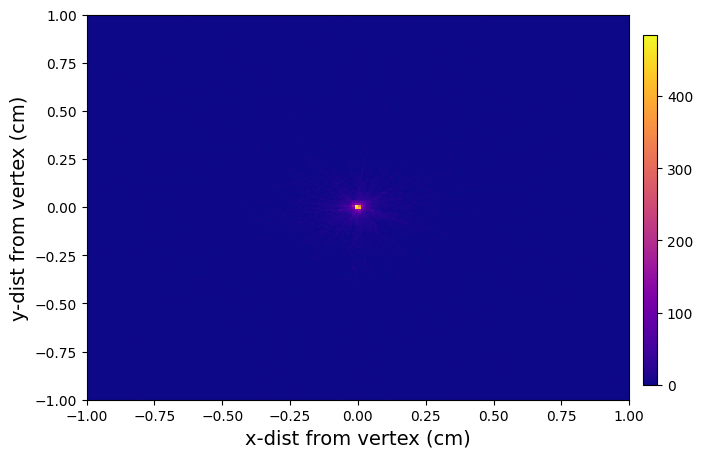

In [172]:
fig, ax = plt.subplots(1, figsize=(7, 5))
hist1 = ax.hist2d(np.asarray(x_rel), np.asarray(y_rel), range=[(-1, 1), (-1, 1)], bins=[200, 200], cmap=mpl.colormaps['plasma'])
ax.set_xlabel("x-dist from vertex (cm)", fontsize=14)
ax.set_ylabel("y-dist from vertex (cm)", fontsize=14)
cbar_ax = fig.add_axes([0.92, 0.14, 0.02, 0.7])
fig.colorbar(hist1[3], cax=cbar_ax)
#plt.savefig("Figures/NeutrinoSim/NeutrinoVertexSim_2dHist_BaseTrackVtxDist_xy.pdf")
plt.show()

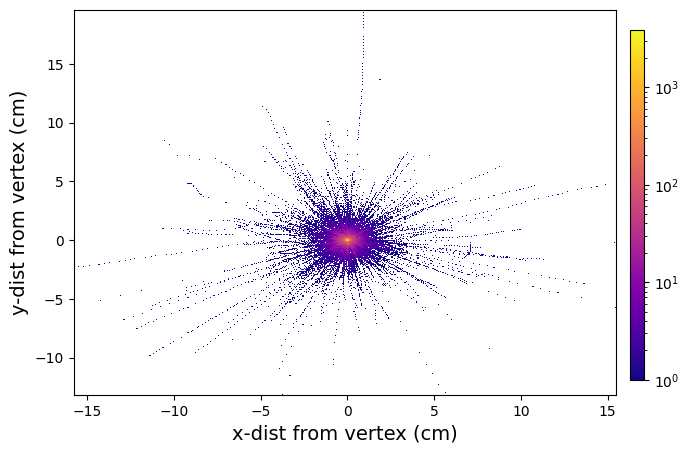

In [166]:
fig, ax = plt.subplots(1, figsize=(7, 5))
# bins=[np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01)],
hist1 = ax.hist2d(np.asarray(x_rel), np.asarray(y_rel), bins=[500, 500],cmap=mpl.colormaps['plasma'], norm=colors.LogNorm())
ax.set_xlabel("x-dist from vertex (cm)", fontsize=14)
ax.set_ylabel("y-dist from vertex (cm)", fontsize=14)
cbar_ax = fig.add_axes([0.92, 0.14, 0.02, 0.7])
fig.colorbar(hist1[3], cax=cbar_ax)
plt.savefig("Figures/NeutrinoSim/NeutrinoVertexSim_2dHist_BaseTrackVtxDist_xy_log.pdf")
plt.show()

Or look at the relative distance to the vertex as a function of one variable at a time

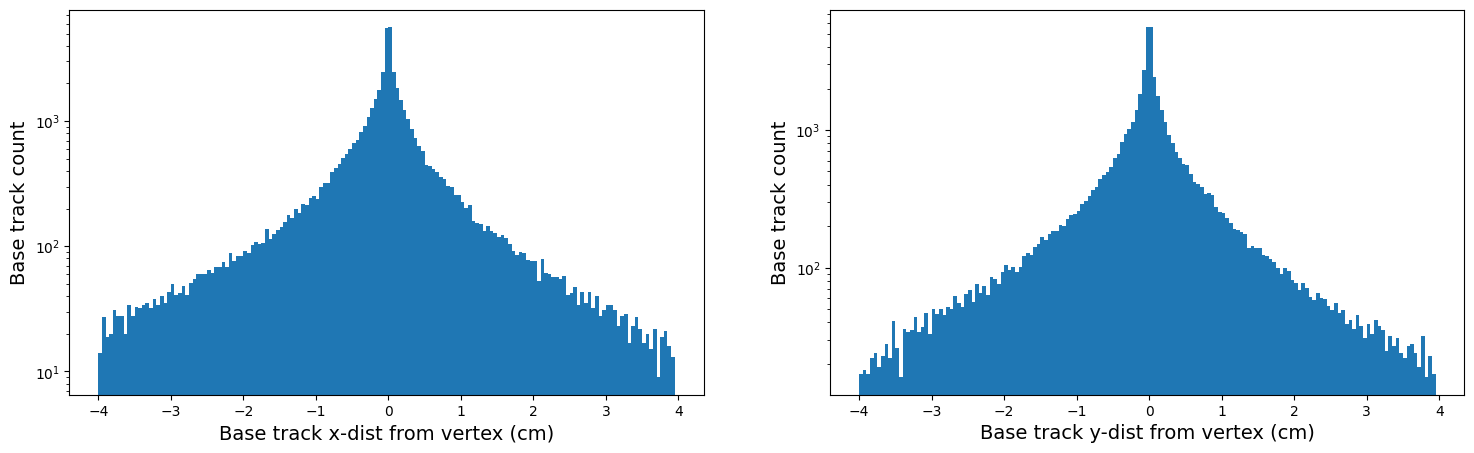

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
ax[0].hist((x_rel), bins=np.arange(-4, 4, 0.05), log=True)
ax[1].hist((y_rel), bins=np.arange(-4, 4, 0.05), log=True)
ax[0].set_xlabel("Base track x-dist from vertex (cm)", fontsize=14)
ax[1].set_xlabel("Base track y-dist from vertex (cm)", fontsize=14)
ax[0].set_ylabel("Base track count", fontsize=14)
ax[1].set_ylabel("Base track count", fontsize=14)
plt.savefig("Figures/NeutrinoSim/NeutrinoVertexSim_1dHist_BaseTrackVtxDist_zoomIn.pdf")
plt.show()

#### Only selecting base tracks close to the vertex

For a mixed simulation, would it make sense to only simulate a small area surrounding the vertices? This way we don't need as many muons. But will we have enough neutrino base tracks for reconstruction in this case?

In [140]:
eff_2_x = len([x for x in x_rel if abs(x)<=1])/len(x_rel)
eff_2_y = len([x for x in y_rel if abs(x)<=1])/len(y_rel)
eff_1_x = len([x for x in x_rel if abs(x)<=0.5])/len(x_rel)
eff_1_y = len([x for x in y_rel if abs(x)<=0.5])/len(y_rel)
eff_half_x = len([x for x in x_rel if abs(x)<=0.25])/len(x_rel)
eff_half_y = len([x for x in y_rel if abs(x)<=0.25])/len(y_rel)
eff_quart_x = len([x for x in x_rel if abs(x)<=0.125])/len(x_rel)
eff_quart_y = len([x for x in y_rel if abs(x)<=0.125])/len(y_rel)

In [141]:
print("Efficiency of 4cm^2: ", eff_2_x*eff_2_y)
print("Efficiency of 1cm^2: ", eff_1_x*eff_1_y)
print("Efficiency of 0.25cm^2: ", eff_half_x*eff_half_y)
print("Efficiency of 0.0625cm^2: ", eff_quart_x*eff_quart_y)
print()
print("4cm^2: x = ", eff_2_x, " and y = ", eff_2_y)
print("1cm^2: x = ", eff_1_x, " and y = ", eff_1_y)
print("0.25cm^2: x = ", eff_half_x, " and y = ", eff_half_y)
print("0.0625cm^2: x = ", eff_quart_x, " and y = ", eff_quart_y)


Efficiency of 4cm^2:  0.6297310601533288
Efficiency of 1cm^2:  0.41476687475802826
Efficiency of 0.25cm^2:  0.24051540837507146
Efficiency of 0.0625cm^2:  0.1251646669733832

4cm^2: x =  0.7974245740190714  and y =  0.7897061122401126
1cm^2: x =  0.6488783804908551  and y =  0.6392058777551978
0.25cm^2: x =  0.4916367047053306  and y =  0.48921369391902453
0.0625cm^2: x =  0.35082851336564014  and y =  0.35676879787400345


In [89]:
plt.rcParams['text.usetex'] = True
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

Look at the selection efficiency of base tracks given these different cuts

In [80]:
# for different z-position bins, figure out what proportion that have the vertices in that bin
width_arr = [1, 0.5, 0.25, 0.125]
z_vals = np.arange(0, 10, 0.2)
x_rel_list = [[x_rel[i] for i in range(len(x_rel)) if (z_vtx[i]>=z_vals[j] and z_vtx[i]<z_vals[j+1])] for j in range(len(z_vals)-1)]
eff_x_vz = [[len([i for i in x if abs(i)<=width])/len(x) if len(x)>0 else 0 for x in x_rel_list] for width in width_arr]

y_rel_list = [[y_rel[i] for i in range(len(y_rel)) if (z_vtx[i]>=z_vals[j] and z_vtx[i]<z_vals[j+1])] for j in range(len(z_vals)-1)]
eff_y_vz = [[len([i for i in y if abs(i)<=width])/len(y) if len(y)>0 else 0 for y in y_rel_list] for width in width_arr]

z_vals = z_vals[:-1]+np.diff(z_vals)/2
eff_area = [[eff_x_vz[w][i]*eff_y_vz[w][i] for i in range(len(eff_x_vz[w]))] for w in range(len(eff_x_vz))]

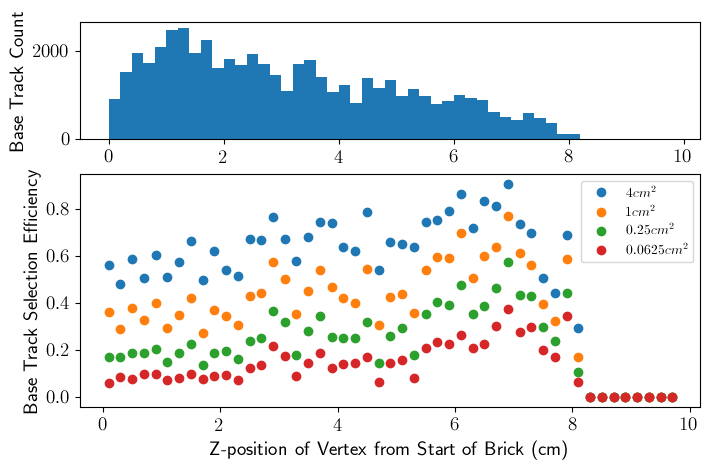

In [97]:
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1,2]}, figsize=(8,5))
ax[0].bar(x=z_vals, height=[len(x) for x in x_rel_list], width = np.diff(z_vals)[0])
label = ['$4cm^2$', '$1cm^2$', '$0.25cm^2$', '$0.0625cm^2$']

for i in range(len(eff_area)):
    ax[1].scatter(z_vals, eff_area[i], label=label[i])
ax[1].legend()
ax[1].set_ylabel("Base Track Selection Efficiency", fontsize=14)
ax[0].set_ylabel("Base Track Count", fontsize=14)
ax[1].set_xlabel("Z-position of Vertex from Start of Brick (cm)", fontsize=14)
plt.savefig("Figures/NeutrinoSim/NeutrinoVertexSim_BaseTrack_AreaEfficiency_vtxZ_scatter.pdf")
plt.show()

In [99]:
min(z_rel)
max(z_rel)

47.586761474609375

Next, make the same plot but with efficiency wrt number of plates after vertex, or efficiency wrt distance of base track to vertex along z -> z_diff

In [109]:
# for different z-position bins, figure out what proportion that have the vertices in that bin
width_arr = [1, 0.5, 0.25, 0.125]
z_vals = np.arange(-8, 15, 0.1)
x_rel_list = [[x_rel[i] for i in range(len(x_rel)) if (z_rel[i]>=z_vals[j] and z_rel[i]<z_vals[j+1])] for j in range(len(z_vals)-1)]
eff_x_vz = [[len([i for i in x if abs(i)<=width])/len(x) if len(x)>0 else 0 for x in x_rel_list] for width in width_arr]

y_rel_list = [[y_rel[i] for i in range(len(y_rel)) if (z_rel[i]>=z_vals[j] and z_rel[i]<z_vals[j+1])] for j in range(len(z_vals)-1)]
eff_y_vz = [[len([i for i in y if abs(i)<=width])/len(y) if len(y)>0 else 0 for y in y_rel_list] for width in width_arr]

z_vals = z_vals[:-1]+np.diff(z_vals)/2
eff_area = [[eff_x_vz[w][i]*eff_y_vz[w][i] for i in range(len(eff_x_vz[w]))] for w in range(len(eff_x_vz))]

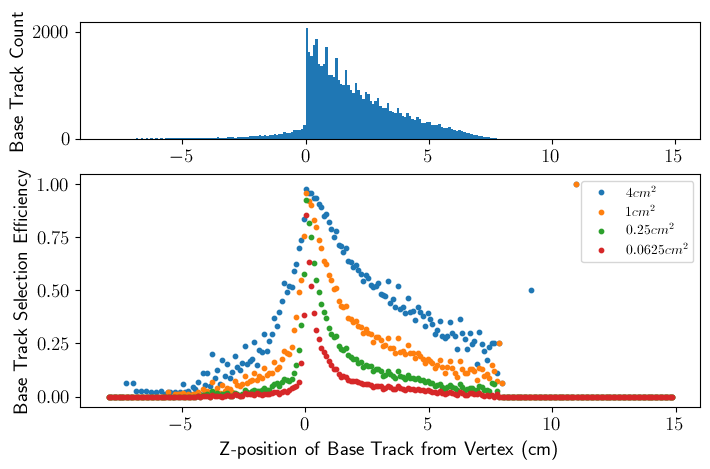

In [118]:
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1,2]}, figsize=(8,5))
ax[0].bar(x=z_vals, height=[len(x) for x in x_rel_list], width = np.diff(z_vals)[0])
label = ['$4cm^2$', '$1cm^2$', '$0.25cm^2$', '$0.0625cm^2$']

for i in range(len(eff_area)):
    ax[1].scatter(z_vals, eff_area[i], label=label[i], s=10)
ax[1].legend()
ax[1].set_ylabel("Base Track Selection Efficiency", fontsize=14)
ax[0].set_ylabel("Base Track Count", fontsize=14)
ax[1].set_xlabel("Z-position of Base Track from Vertex (cm)", fontsize=14)
plt.savefig("Figures/NeutrinoSim/NeutrinoVertexSim_BaseTrack_AreaEfficiency_trackZ_scatter.pdf")
plt.show()

## Repeat the above steps with cuts on the momentum and charge

Specifically, momentum > 100 MeV (data has momentum in GeV, so 0.1) and charged (so that it will be seen in the emulsion). From above, it seems that the far away tracks are the ones with very high angle and very low energy, so they wouldn't be seen in the reconstruction anyways so it's ok to have them omitted

In [11]:
charge = dict([(Particle.findall()[i].pdgid, Particle.findall()[i].charge) for i in range((6496))])

In [12]:
x_rel = []
y_rel = []
z_rel = []
x_angle_cut = []
y_angle_cut = []

branchnames = ["MCTrack/MCTrack.fStartX", "MCTrack/MCTrack.fStartY", "MCTrack/MCTrack.fStartZ", "MCTrack/MCTrack.fMotherId", "EmulsionDetPoint/EmulsionDetPoint.fX", "EmulsionDetPoint/EmulsionDetPoint.fY", "EmulsionDetPoint/EmulsionDetPoint.fZ", "EmulsionDetPoint/EmulsionDetPoint.fTrackID", "EmulsionDetPoint/EmulsionDetPoint.fPdgCode", "EmulsionDetPoint/EmulsionDetPoint.fPx", "EmulsionDetPoint/EmulsionDetPoint.fPy", "EmulsionDetPoint/EmulsionDetPoint.fPz"]
# truesim = truesim_tree.arrays(branchnames, entry_start = 0, entry_stop = 1000)
for truesim in truesim_tree.iterate(branchnames, step_size=500):
    # get track number
    truesim['MCTrack/MCTrack.fTrackID'] = [range(1, len(truesim['MCTrack/MCTrack.fStartX'][i])+1) for i in range(len(truesim['MCTrack/MCTrack.fStartX']))]
    # get charge
    trackpdgs = truesim["EmulsionDetPoint/EmulsionDetPoint.fPdgCode"]
    trackcharge = []
    for eventi in range(len(trackpdgs)):
        if len(trackpdgs[eventi])>0:
            trackcharge.append(np.vectorize(charge.get)(trackpdgs[eventi]))
        else:
            trackcharge.append([])
    truesim['EmulsionDetPoint/EmulsionDetPoint.fCharge'] = ak.Array(trackcharge)

    # loop through hits
    for e in range(len(truesim['MCTrack/MCTrack.fTrackID'])): # this is the event number
        for t in range(len(truesim['EmulsionDetPoint/EmulsionDetPoint.fTrackID'][e])): # this is the track number
            tracknum = truesim['EmulsionDetPoint/EmulsionDetPoint.fTrackID'][e][t]
            p = math.sqrt(truesim['EmulsionDetPoint/EmulsionDetPoint.fPx'][e][t]**2 + truesim['EmulsionDetPoint/EmulsionDetPoint.fPy'][e][t]**2 + truesim['EmulsionDetPoint/EmulsionDetPoint.fPz'][e][t]**2)
            charge = truesim['EmulsionDetPoint/EmulsionDetPoint.fCharge'][e][t]
            if tracknum>=0 and p>=0.1 and charge!=0 and truesim['MCTrack/MCTrack.fMotherId'][e][tracknum-1]==0:
                x = truesim['EmulsionDetPoint/EmulsionDetPoint.fX'][e][t] 
                y = truesim['EmulsionDetPoint/EmulsionDetPoint.fY'][e][t]
                z = truesim['EmulsionDetPoint/EmulsionDetPoint.fZ'][e][t] 
                # find the track with the same track number

                v_x = truesim['MCTrack/MCTrack.fStartX'][e][tracknum-1]
                v_y = truesim['MCTrack/MCTrack.fStartY'][e][tracknum-1]
                v_z = truesim['MCTrack/MCTrack.fStartZ'][e][tracknum-1]
                x_new, y_new, z_new = getHits(x, y, z, v_x, v_y, v_z)
                # print(t, "out of", len(truesim['EmulsionDetPoint/EmulsionDetPoint.fTrackID'][e]))
                if x_new!=None:
                    x_angle_cut += [np.arctan2(truesim['EmulsionDetPoint/EmulsionDetPoint.fPx'][e][t], truesim['EmulsionDetPoint/EmulsionDetPoint.fPz'][e][t])]
                    y_angle_cut += [np.arctan2(truesim['EmulsionDetPoint/EmulsionDetPoint.fPy'][e][t], truesim['EmulsionDetPoint/EmulsionDetPoint.fPz'][e][t])]
                    x_rel += [x_new]
                    y_rel += [y_new]
                    z_rel += [z_new]
            else:
                break
        print(e)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

AttributeError: 'numpy.float64' object has no attribute 'get'

In [9]:
len(x_rel)

2505

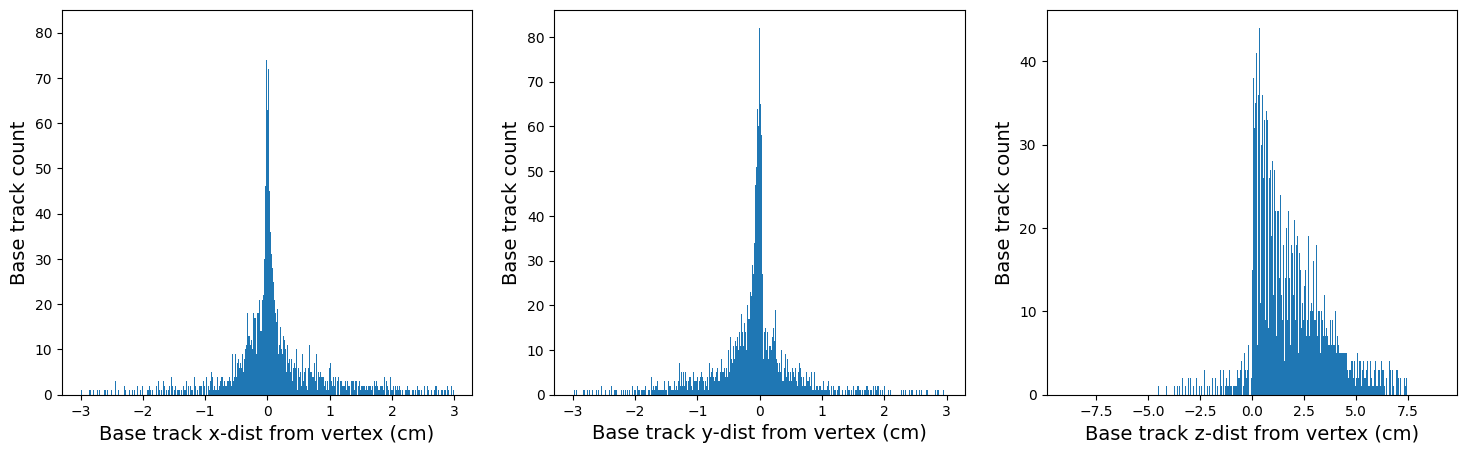

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].hist(np.asarray(x_rel), bins=np.arange(-3, 3, 0.01))
ax[1].hist(np.asarray(y_rel), bins=np.arange(-3, 3, 0.01))
ax[2].hist(np.asarray(z_rel), bins=np.arange(-9, 9, 0.03))
ax[0].set_xlabel("Base track x-dist from vertex (cm)", fontsize=14)
ax[1].set_xlabel("Base track y-dist from vertex (cm)", fontsize=14)
ax[2].set_xlabel("Base track z-dist from vertex (cm)", fontsize=14)
ax[0].set_ylabel("Base track count", fontsize=14)
ax[1].set_ylabel("Base track count", fontsize=14)
ax[2].set_ylabel("Base track count", fontsize=14)
ax[2].ticklabel_format(style='sci', scilimits=(0, 3))
plt.savefig("Figures/NeutrinoSim/NeutrinoVertexSim_1dHist_BaseTrackVtxDist_charged_p>100MeV_cut.pdf")
plt.show()

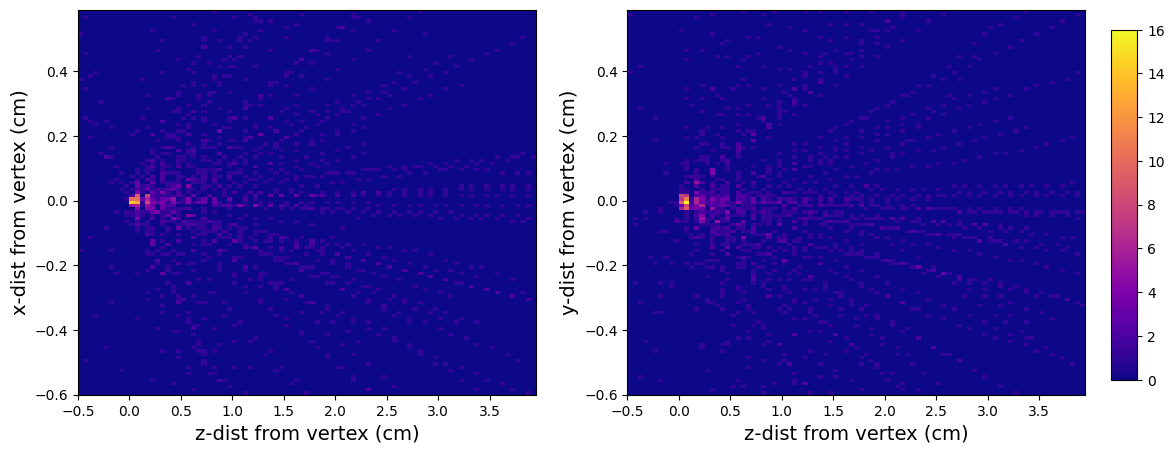

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
hist1 = ax[0].hist2d(np.asarray(z_rel), np.asarray(x_rel), bins=[np.arange(-0.5, 4, 0.05), np.arange(-0.6, 0.6, 0.01)], vmax=16, cmap=mpl.colormaps['plasma'])
hist2 = ax[1].hist2d(np.asarray(z_rel), np.asarray(y_rel), bins=[np.arange(-0.5, 4, 0.05), np.arange(-0.6, 0.6, 0.01)], vmax=16, cmap=mpl.colormaps['plasma'])
ax[0].set_xlabel("z-dist from vertex (cm)", fontsize=14)
ax[1].set_xlabel("z-dist from vertex (cm)", fontsize=14)
ax[0].set_ylabel("x-dist from vertex (cm)", fontsize=14)
ax[1].set_ylabel("y-dist from vertex (cm)", fontsize=14)
cbar_ax = fig.add_axes([0.92, 0.14, 0.02, 0.7])
fig.colorbar(hist2[3], cax=cbar_ax)
plt.savefig("Figures/NeutrinoSim/NeutrinoVertexSim_2dHist_BaseTrackVtxDist_charged_p>100MeV_cut.pdf")
plt.show()

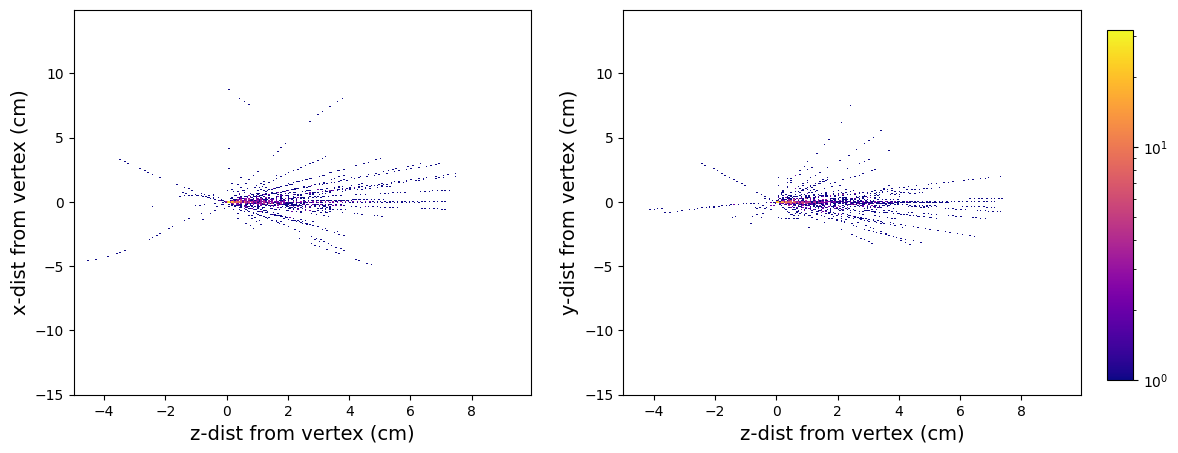

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
# bins=[np.arange(-1, 15, 0.05), np.arange(-5, 5, 0.05)]
hist1 = ax[0].hist2d(np.asarray(z_rel), np.asarray(x_rel), bins=[np.arange(-5, 10, 0.05), np.arange(-15, 15, 0.05)], cmap=mpl.colormaps['plasma'], norm=colors.LogNorm(vmin=1, vmax=32))
hist2 = ax[1].hist2d(np.asarray(z_rel), np.asarray(y_rel), bins=[np.arange(-5, 10, 0.05), np.arange(-15, 15, 0.05)], cmap=mpl.colormaps['plasma'], norm=colors.LogNorm(vmin=1, vmax=32))
ax[0].set_xlabel("z-dist from vertex (cm)", fontsize=14)
ax[1].set_xlabel("z-dist from vertex (cm)", fontsize=14)
ax[0].set_ylabel("x-dist from vertex (cm)", fontsize=14)
ax[1].set_ylabel("y-dist from vertex (cm)", fontsize=14)
cbar_ax = fig.add_axes([0.92, 0.14, 0.02, 0.7])
fig.colorbar(hist2[3], cax=cbar_ax)
plt.savefig("Figures/NeutrinoSim/NeutrinoVertexSim_2dHist_BaseTrackVtxDist_log_charged_p>100MeV_cut.pdf")
plt.show()

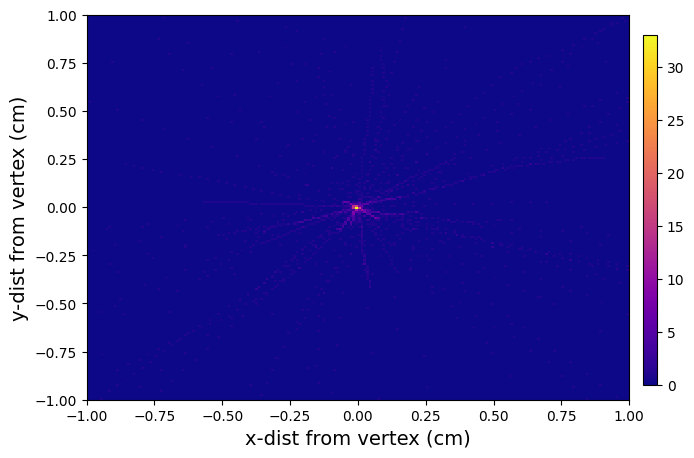

In [20]:
fig, ax = plt.subplots(1, figsize=(7, 5))
hist1 = ax.hist2d(np.asarray(x_rel), np.asarray(y_rel), range=[(-1, 1), (-1, 1)], bins=[200, 200], cmap=mpl.colormaps['plasma'])
ax.set_xlabel("x-dist from vertex (cm)", fontsize=14)
ax.set_ylabel("y-dist from vertex (cm)", fontsize=14)
cbar_ax = fig.add_axes([0.92, 0.14, 0.02, 0.7])
fig.colorbar(hist1[3], cax=cbar_ax)
plt.savefig("Figures/NeutrinoSim/NeutrinoVertexSim_2dHist_BaseTrackVtxDist_xy_charged_p>100MeV_cut.pdf")
plt.show()

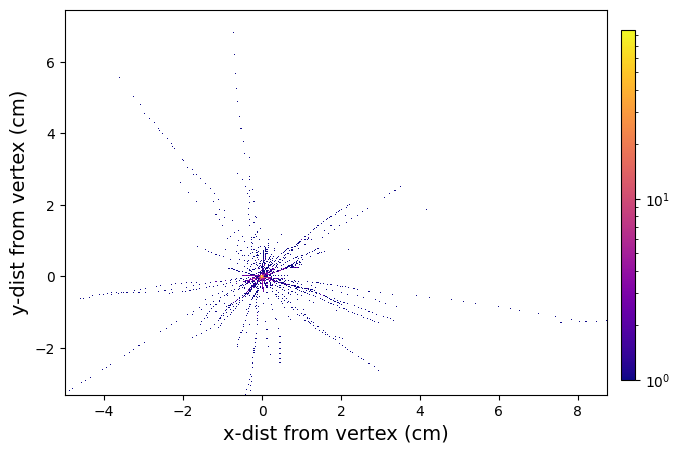

In [21]:
fig, ax = plt.subplots(1, figsize=(7, 5))
# bins=[np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01)],
hist1 = ax.hist2d(np.asarray(x_rel), np.asarray(y_rel), bins=[500, 500],cmap=mpl.colormaps['plasma'], norm=colors.LogNorm())
ax.set_xlabel("x-dist from vertex (cm)", fontsize=14)
ax.set_ylabel("y-dist from vertex (cm)", fontsize=14)
cbar_ax = fig.add_axes([0.92, 0.14, 0.02, 0.7])
fig.colorbar(hist1[3], cax=cbar_ax)
plt.savefig("Figures/NeutrinoSim/NeutrinoVertexSim_2dHist_BaseTrackVtxDist_xy_log_charged_p>100MeV_cut.pdf")
plt.show()

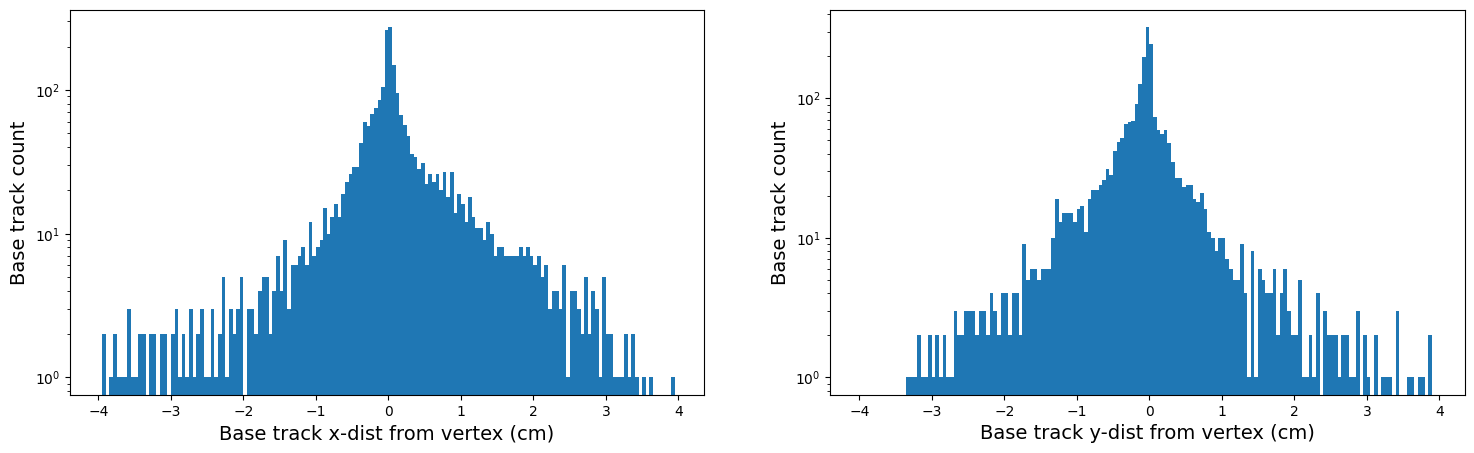

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
ax[0].hist((x_rel), bins=np.arange(-4, 4, 0.05), log=True)
ax[1].hist((y_rel), bins=np.arange(-4, 4, 0.05), log=True)
ax[0].set_xlabel("Base track x-dist from vertex (cm)", fontsize=14)
ax[1].set_xlabel("Base track y-dist from vertex (cm)", fontsize=14)
ax[0].set_ylabel("Base track count", fontsize=14)
ax[1].set_ylabel("Base track count", fontsize=14)
plt.savefig("Figures/NeutrinoSim/NeutrinoVertexSim_1dHist_BaseTrackVtxDist_zoomIn_charged_p>100MeV_cut.pdf")
plt.show()

In [23]:
eff_2_x = len([x for x in x_rel if abs(x)<=1])/len(x_rel)
eff_2_y = len([x for x in y_rel if abs(x)<=1])/len(y_rel)
eff_1_x = len([x for x in x_rel if abs(x)<=0.5])/len(x_rel)
eff_1_y = len([x for x in y_rel if abs(x)<=0.5])/len(y_rel)
eff_half_x = len([x for x in x_rel if abs(x)<=0.25])/len(x_rel)
eff_half_y = len([x for x in y_rel if abs(x)<=0.25])/len(y_rel)
eff_quart_x = len([x for x in x_rel if abs(x)<=0.125])/len(x_rel)
eff_quart_y = len([x for x in y_rel if abs(x)<=0.125])/len(y_rel)

In [24]:
print("Efficiency of 4cm^2: ", eff_2_x*eff_2_y)
print("Efficiency of 1cm^2: ", eff_1_x*eff_1_y)
print("Efficiency of 0.25cm^2: ", eff_half_x*eff_half_y)
print("Efficiency of 0.0625cm^2: ", eff_quart_x*eff_quart_y)
print()
print("4cm^2: x = ", eff_2_x, " and y = ", eff_2_y)
print("1cm^2: x = ", eff_1_x, " and y = ", eff_1_y)
print("0.25cm^2: x = ", eff_half_x, " and y = ", eff_half_y)
print("0.0625cm^2: x = ", eff_quart_x, " and y = ", eff_quart_y)


Efficiency of 4cm^2:  0.6747928494308788
Efficiency of 1cm^2:  0.45092617160887805
Efficiency of 0.25cm^2:  0.25605236632523376
Efficiency of 0.0625cm^2:  0.13145955593802414

4cm^2: x =  0.7996007984031936  and y =  0.8439121756487026
1cm^2: x =  0.6502994011976048  and y =  0.6934131736526946
0.25cm^2: x =  0.4930139720558882  and y =  0.5193612774451097
0.0625cm^2: x =  0.34810379241516964  and y =  0.3776447105788423


## Plot the angular distribution of the tracks

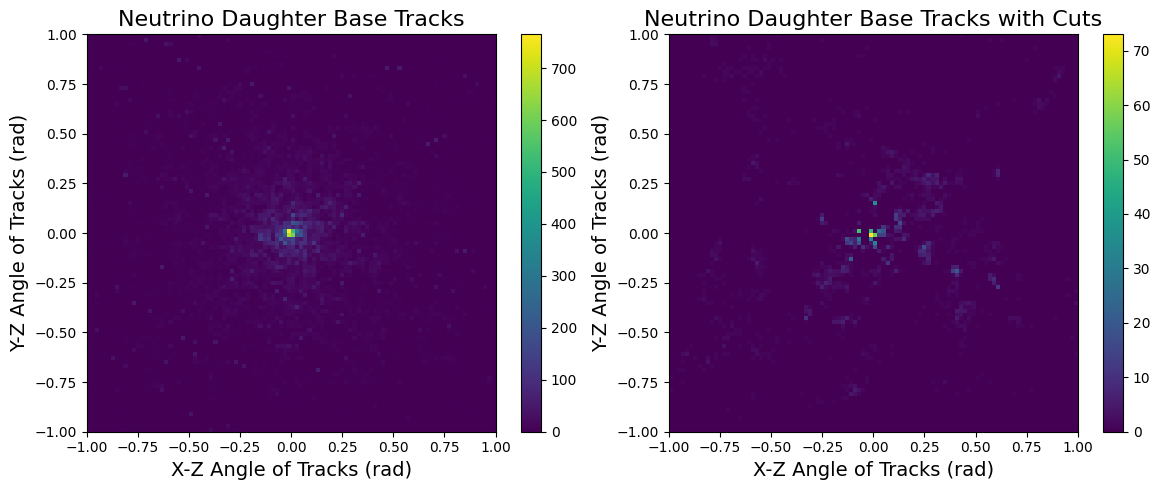

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12,5), tight_layout=True)
hist1 = ax[0].hist2d(x_angle, y_angle, range=((-1, 1),(-1, 1)), bins=100)# the first track is always the neutrino
ax[0].set_xlabel("X-Z Angle of Tracks (rad)", fontsize=14)
ax[0].set_ylabel("Y-Z Angle of Tracks (rad)", fontsize=14)
ax[0].set_title("Neutrino Daughter Base Tracks", fontsize=16)

hist2 = ax[1].hist2d(x_angle_cut, y_angle_cut, range=((-1, 1),(-1, 1)), bins=100)
ax[1].set_xlabel("X-Z Angle of Tracks (rad)", fontsize=14)
ax[1].set_ylabel("Y-Z Angle of Tracks (rad)", fontsize=14)
ax[1].set_title("Neutrino Daughter Base Tracks with Cuts", fontsize=16)

#ax[0].set_yticks(np.arange(-0.1, 0.1, 0.04999))
#ax[1].set_yticks(np.arange(-0.1, 0.1, 0.04999))
fig.colorbar(hist1[3], ax=ax[0])
fig.colorbar(hist2[3], ax=ax[1])

fig.tight_layout()
plt.grid(False)
plt.savefig("Figures/NeutrinoSim/AngularDist_2dHist_EmulsionHits_NeutrinoDaughters_withAndWithoutCuts.pdf")
plt.show()

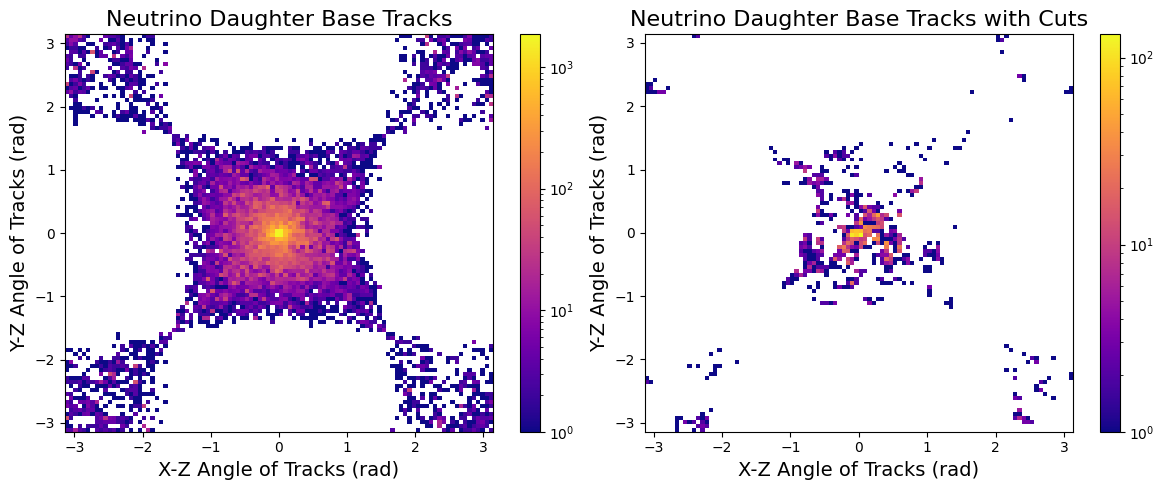

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12,5), tight_layout=True)
hist1 = ax[0].hist2d(x_angle, y_angle, bins=100, cmap=mpl.colormaps['plasma'], norm=colors.LogNorm())
ax[0].set_xlabel("X-Z Angle of Tracks (rad)", fontsize=14)
ax[0].set_ylabel("Y-Z Angle of Tracks (rad)", fontsize=14)
ax[0].set_title("Neutrino Daughter Base Tracks", fontsize=16)

hist2 = ax[1].hist2d(x_angle_cut, y_angle_cut, bins=100, cmap=mpl.colormaps['plasma'], norm=colors.LogNorm())
ax[1].set_xlabel("X-Z Angle of Tracks (rad)", fontsize=14)
ax[1].set_ylabel("Y-Z Angle of Tracks (rad)", fontsize=14)
ax[1].set_title("Neutrino Daughter Base Tracks with Cuts", fontsize=16)

#ax[0].set_yticks(np.arange(-0.1, 0.1, 0.04999))
#ax[1].set_yticks(np.arange(-0.1, 0.1, 0.04999))
fig.colorbar(hist1[3], ax=ax[0])
fig.colorbar(hist2[3], ax=ax[1])

fig.tight_layout()
plt.grid(False)
plt.savefig("Figures/NeutrinoSim/AngularDist_2dHist_EmulsionHits_NeutrinoDaughters_withAndWithoutCuts_log.pdf")
plt.show()

## Daughter Particles

Let's look more closely at the neutrino daughters

In [127]:
daughter_arr = [(truesim['MCTrack/MCTrack.fEventId'][i], truesim['MCTrack/MCTrack.fTrackId'][i], truesim['MCTrack/MCTrack.fMotherId'][i]) for i in range(len(truesim['MCTrack/MCTrack.fMotherId']))]
                
                

In [163]:
arr = [truesim['MCTrack/MCTrack.fMotherId']

In [173]:
[np.count_nonzero(i==0) for i in arr]

[15,
 7,
 15,
 13,
 7,
 7,
 11,
 11,
 7,
 15,
 8,
 8,
 4,
 15,
 7,
 6,
 13,
 13,
 13,
 11,
 10,
 12,
 11,
 9,
 3,
 13,
 14,
 4,
 14,
 13,
 10,
 13,
 17,
 13,
 14,
 18,
 20,
 10,
 14,
 8,
 6,
 9,
 15,
 3,
 14,
 12,
 8,
 14,
 11,
 14,
 12,
 11,
 6,
 2,
 11,
 5,
 16,
 13,
 6,
 14,
 27,
 9,
 5,
 13,
 8,
 12,
 12,
 8,
 8,
 6,
 14,
 10,
 29,
 11,
 21,
 10,
 5,
 11,
 11,
 9,
 10,
 16,
 8,
 11,
 13,
 10,
 16,
 5,
 6,
 13,
 18,
 15,
 12,
 8,
 11,
 13,
 5,
 13,
 7,
 8,
 15,
 3,
 5,
 9,
 9,
 10,
 11,
 12,
 8,
 12,
 7,
 13,
 17,
 6,
 16,
 9,
 12,
 11,
 8,
 12,
 7,
 17,
 15,
 8,
 13,
 22,
 10,
 16,
 8,
 15,
 8,
 9,
 7,
 14,
 12,
 6,
 13,
 16,
 2,
 16,
 7,
 13,
 8,
 12,
 13,
 10,
 15,
 8,
 22,
 8,
 12,
 4,
 24,
 20,
 12,
 6,
 8,
 6,
 6,
 4,
 2,
 24,
 13,
 15,
 6,
 11,
 16,
 8,
 15,
 11,
 9,
 9,
 8,
 12,
 17,
 13,
 10,
 5,
 13,
 9,
 8,
 11,
 12,
 3,
 12,
 12,
 14,
 15,
 10,
 16,
 13,
 8,
 8,
 16,
 5,
 10,
 10,
 9,
 12,
 14,
 11,
 14,
 5,
 8,
 4,
 9,
 12,
 6,
 13,
 9,
 3,
 16,
 15,
 5,
 7,
 6,
 13,
 1

This gives us the eventID, trackID, and MotherID for the events with at least 3 tracks, more than half of which are neutrino daughters: 

In [158]:
sim_daughters = [[evt, track, daughter] for (evt, track, daughter) in daughter_arr] # if (len(daughter)>=3) and (np.count_nonzero(daughter==0))>=2] #len(daughter)/2]
#sim_daughters = [[evt, track, daughter] for (evt, track, daughter) in daughter_arr]

In [183]:
len(sim_daughters)

7480

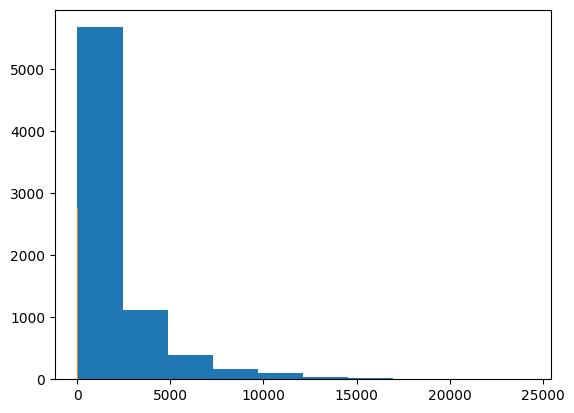

In [174]:
fig, ax = plt.subplots()
ax.hist([len(i) for i in arr])
ax.hist([np.count_nonzero(i==0) for i in arr])
plt.show()

We're looking at 71 neutrino events. Now let's look at the vertices and see how many of these events are reconstructed: 

In [180]:
count = 0
for evt in sim_daughters:
    arr = np.where(total_vtx['MCEventID'][:,0]==evt[0])[0]
    if(len(arr)>0):
        print(evt[0], evt[1])
        count += 1

1 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 8026, 8027, 8028, 8029, 8030, 8031, 8032, 8033]
2 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457]
3 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 467, 468, 469, 470, 471, 472, 473, 474, 475]
4 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 700, 701, 702, 703, 704, 705, 706, 707, 708]
5 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 833, 834, 835, 836, 837, 838, 839, 840, 841]
6 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 217, 218, 219, 220, 221, 222, 223, 224, 225]
7 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 965, 966, 967, 968, 969, 970, 971, 972, 973]
9 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 158, 159, 160, 161, 162, 163, 164, 165, 166]
10 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066]
11 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 464, 465, 466, 467, 468, 469, 470, 471, 472]
12 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 255, 256, 257, 258, 259, 260, 261, 262, 263]
13 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
1

139 [0, 1, 2, 3, 4, 5, 6, 7]
140 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499]
141 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]
142 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 919, 920, 921, 922, 923, 924, 925, 926, 927]
143 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 306, 307, 308, 309, 310, 311, 312, 313, 314]
144 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 724, 725, 726, 727, 728, 729, 730, 731, 732]
145 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 380, 381, 382, 383, 384, 385, 386, 387, 388]
147 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 4834, 4835, 4836, 4837, 4838, 4839, 4840, 4841]
148 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 556, 557, 558, 559, 560, 561, 562, 563, 564]
149 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 9914, 9915, 9916, 9917, 9918, 9919, 9920, 9921]
150 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]
151 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062]
152 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 4

293 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 152, 153, 154, 155, 156, 157, 158, 159, 160]
294 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 259, 260, 261, 262, 263, 264, 265, 266, 267]
295 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 369, 370, 371, 372, 373, 374, 375, 376, 377]
296 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
297 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 934, 935, 936, 937, 938, 939, 940, 941, 942]
298 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 8631, 8632, 8633, 8634, 8635, 8636, 8637, 8638]
299 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 480, 481, 482, 483, 484, 485, 486, 487, 488]
300 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986]
302 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 93, 94, 95, 96, 97, 98, 99, 100, 101, 102]
303 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053]
306 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]
308 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1114, 1115, 1116, 1117, 1118, 11

441 [0, 1, 2, 3, 4, 5, 6, 7]
442 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705]
443 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 611, 612, 613, 614, 615, 616, 617, 618, 619]
444 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 4817, 4818, 4819, 4820, 4821, 4822, 4823, 4824]
445 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164]
446 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079]
447 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
448 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327]
449 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 331, 332, 333, 334, 335, 336, 337, 338, 339]
450 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631]
452 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092]
453 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162]
454 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..

590 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 209, 210, 211, 212, 213, 214, 215, 216, 217]
591 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024]
592 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525]
594 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154]
596 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484]
597 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823]
599 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 360, 361, 362, 363, 364, 365, 366, 367, 368]
600 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3221]
601 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343]
602 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571]
603 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 4939, 4940, 4941, 4942, 4943, 4944, 4945, 4946]
605 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 199, 200, 201, 202, 203, 

739 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065]
740 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167]
741 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 314, 315, 316, 317, 318, 319, 320, 321, 322]
742 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282]
743 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977]
744 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 299, 300, 301, 302, 303, 304, 305, 306, 307]
745 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 655, 656, 657, 658, 659, 660, 661, 662, 663]
746 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595]
747 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 4527, 4528, 4529, 4530, 4531, 4532, 4533, 4534]
748 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 746, 747, 748, 749, 750, 751, 752, 753, 754]
749 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 396, 397, 398, 399, 400, 401, 402, 403, 404]
750 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2050, 2051, 2052, 2053, 2054

887 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 113, 114, 115, 116, 117, 118, 119, 120, 121]
888 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990]
889 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 371, 372, 373, 374, 375, 376, 377, 378, 379]
890 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 8030, 8031, 8032, 8033, 8034, 8035, 8036, 8037]
891 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957]
892 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 451, 452, 453, 454, 455, 456, 457, 458, 459]
893 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 545, 546, 547, 548, 549, 550, 551, 552, 553]
894 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 4155, 4156, 4157, 4158, 4159, 4160, 4161, 4162]
896 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
897 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 976, 977, 978, 979, 980, 981, 982, 983, 984]
898 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347]
899 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1896, 1897, 1898, 1899, 1900,

1026 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 149, 150, 151, 152, 153, 154, 155, 156, 157]
1027 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 4002, 4003, 4004, 4005, 4006, 4007, 4008, 4009]
1028 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360]
1029 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060]
1030 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813]
1031 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570]
1032 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 242, 243, 244, 245, 246, 247, 248, 249, 250]
1033 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 440, 441, 442, 443, 444, 445, 446, 447, 448]
1034 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
1036 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
1037 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723]
1038 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3972, 3973, 3974, 

1176 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482]
1177 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 710, 711, 712, 713, 714, 715, 716, 717, 718]
1180 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008]
1181 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752]
1182 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]
1183 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522]
1184 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 120, 121, 122, 123, 124, 125, 126, 127, 128]
1185 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 707, 708, 709, 710, 711, 712, 713, 714, 715]
1186 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753]
1188 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 103, 104, 105, 106, 107, 108, 109, 110, 111]
1190 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
1191 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 436, 437, 438, 

1331 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 987, 988, 989, 990, 991, 992, 993, 994, 995]
1332 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 820, 821, 822, 823, 824, 825, 826, 827, 828]
1333 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048]
1334 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 388, 389, 390, 391, 392, 393, 394, 395, 396]
1335 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 259, 260, 261, 262, 263, 264, 265, 266, 267]
1336 [0, 1, 2, 3, 4, 5, 6, 7, ..., 14138, 14139, 14140, 14141, 14142, 14143, 14144]
1337 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
1338 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 665, 666, 667, 668, 669, 670, 671, 672, 673]
1339 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 568, 569, 570, 571, 572, 573, 574, 575, 576]
1340 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 770, 771, 772, 773, 774, 775, 776, 777, 778]
1341 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265]
1343 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1

1480 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 175, 176, 177, 178, 179, 180, 181, 182, 183]
1481 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 783, 784, 785, 786, 787, 788, 789, 790, 791]
1482 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 903, 904, 905, 906, 907, 908, 909, 910, 911]
1483 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746]
1484 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 7199, 7200, 7201, 7202, 7203, 7204, 7205, 7206]
1485 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 594, 595, 596, 597, 598, 599, 600, 601, 602]
1486 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 972, 973, 974, 975, 976, 977, 978, 979, 980]
1487 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751]
1488 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 101, 102, 103, 104, 105, 106, 107, 108, 109]
1489 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 927, 928, 929, 930, 931, 932, 933, 934, 935]
1490 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 915, 916, 917, 918, 919, 920, 921, 922, 923]
1491 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 730, 731, 732

1626 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 566, 567, 568, 569, 570, 571, 572, 573, 574]
1627 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 125, 126, 127, 128, 129, 130, 131, 132, 133]
1628 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 368, 369, 370, 371, 372, 373, 374, 375, 376]
1629 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796]
1630 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143]
1631 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957]
1632 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 306, 307, 308, 309, 310, 311, 312, 313, 314]
1633 [0, 1, 2, 3, 4, 5, 6, 7, ..., 10941, 10942, 10943, 10944, 10945, 10946, 10947]
1634 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
1636 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 906, 907, 908, 909, 910, 911, 912, 913, 914]
1637 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 438, 439, 440, 441, 442, 443, 444, 445, 446]
1638 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 5166, 5167, 5168, 5

1776 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
1777 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 520, 521, 522, 523, 524, 525, 526, 527, 528]
1778 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 769, 770, 771, 772, 773, 774, 775, 776, 777]
1779 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043]
1780 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 4641, 4642, 4643, 4644, 4645, 4646, 4647, 4648]
1781 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 264, 265, 266, 267, 268, 269, 270, 271, 272]
1782 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
1783 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195]
1784 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880]
1786 [0, 1, 2, 3, 4, 5]
1787 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 277, 278, 279, 280, 281, 282, 283, 284, 285]
1789 [0, 1, 2, 3, 4, 5, 6, 7, 8]
1790 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]


1927 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
1928 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 397, 398, 399, 400, 401, 402, 403, 404, 405]
1929 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007]
1930 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 152, 153, 154, 155, 156, 157, 158, 159, 160]
1931 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811]
1932 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412]
1933 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
1934 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 536, 537, 538, 539, 540, 541, 542, 543, 544]
1936 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
1937 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613]
1938 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063]
1939 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 158, 159, 160, 1

2076 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843]
2077 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204]
2078 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 428, 429, 430, 431, 432, 433, 434, 435, 436]
2079 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
2080 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913]
2081 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504]
2082 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857]
2083 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 613, 614, 615, 616, 617, 618, 619, 620, 621]
2084 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798]
2085 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 465, 466, 467, 468, 469, 470, 471, 472, 473]
2087 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
2089 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 9413, 9414, 9415, 9416, 9417, 9418, 9419, 9420]
2090 [0, 1

2222 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 673, 674, 675, 676, 677, 678, 679, 680, 681]
2223 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 719, 720, 721, 722, 723, 724, 725, 726, 727]
2224 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
2225 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069]
2226 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 901, 902, 903, 904, 905, 906, 907, 908, 909]
2227 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 950, 951, 952, 953, 954, 955, 956, 957, 958]
2228 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523]
2229 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 181, 182, 183, 184, 185, 186, 187, 188, 189]
2230 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741]
2231 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 439, 440, 441, 442, 443, 444, 445, 446, 447]
2232 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 220, 221, 222, 223, 224, 225, 226, 227, 228]
2233 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 78, 79, 80

2372 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
2373 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 816, 817, 818, 819, 820, 821, 822, 823, 824]
2375 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
2377 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 362, 363, 364, 365, 366, 367, 368, 369, 370]
2378 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175]
2379 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457]
2380 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723]
2381 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098]
2382 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 401, 402, 403, 404, 405, 406, 407, 408, 409]
2383 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 8995, 8996, 8997, 8998, 8999, 9000, 9001, 9002]
2384 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071]
2385 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601]
2386 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1012, 

2521 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 330, 331, 332, 333, 334, 335, 336, 337, 338]
2524 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739]
2525 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 571, 572, 573, 574, 575, 576, 577, 578, 579]
2526 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 6495, 6496, 6497, 6498, 6499, 6500, 6501, 6502]
2527 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050]
2528 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 335, 336, 337, 338, 339, 340, 341, 342, 343]
2529 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614]
2530 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3784, 3785, 3786, 3787, 3788, 3789, 3790, 3791]
2531 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 589, 590, 591, 592, 593, 594, 595, 596, 597]
2532 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 249, 250, 251, 252, 253, 254, 255, 256, 257]
2533 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396]
2534 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 57, 58, 5

2666 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 335, 336, 337, 338, 339, 340, 341, 342, 343]
2667 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 136, 137, 138, 139, 140, 141, 142, 143, 144]
2668 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 812, 813, 814, 815, 816, 817, 818, 819, 820]
2669 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]
2673 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
2674 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210]
2675 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046]
2676 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 854, 855, 856, 857, 858, 859, 860, 861, 862]
2677 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
2679 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 489, 490, 491, 492, 493, 494, 495, 496, 497]
2680 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897]
2681 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 269, 270, 271, 2

2815 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 6331, 6332, 6333, 6334, 6335, 6336, 6337, 6338]
2816 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051]
2817 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 266, 267, 268, 269, 270, 271, 272, 273, 274]
2818 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 526, 527, 528, 529, 530, 531, 532, 533, 534]
2819 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547]
2820 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 203, 204, 205, 206, 207, 208, 209, 210, 211]
2821 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 376, 377, 378, 379, 380, 381, 382, 383, 384]
2822 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 9149, 9150, 9151, 9152, 9153, 9154, 9155, 9156]
2823 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 463, 464, 465, 466, 467, 468, 469, 470, 471]
2825 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
2826 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685]
2827 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 251, 252, 253, 254, 255, 256, 257, 258, 259]
2829 [0, 1

2970 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219]
2971 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370]
2972 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 6741, 6742, 6743, 6744, 6745, 6746, 6747, 6748]
2973 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 402, 403, 404, 405, 406, 407, 408, 409, 410]
2974 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 614, 615, 616, 617, 618, 619, 620, 621, 622]
2975 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 5116, 5117, 5118, 5119, 5120, 5121, 5122, 5123]
2976 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 712, 713, 714, 715, 716, 717, 718, 719, 720]
2978 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2979 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 923, 924, 925, 926, 927, 928, 929, 930, 931]
2980 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322]
2981 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 9948, 9949, 9950, 9951, 9952, 9953, 9954, 9955]
2982 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 747, 748, 749, 750, 751, 752, 753, 754, 755]
2983 [

3115 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475]
3116 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414]
3117 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500]
3118 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520]
3119 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
3120 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 815, 816, 817, 818, 819, 820, 821, 822, 823]
3121 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603]
3122 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098]
3123 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 331, 332, 333, 334, 335, 336, 337, 338, 339]
3124 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 4290, 4291, 4292, 4293, 4294, 4295, 4296, 4297]
3125 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 126, 127, 128, 129, 130, 131, 132, 133, 134]
3126 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 511, 512, 513, 514, 515, 516, 517, 518, 519

3259 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 109, 110, 111, 112, 113, 114, 115, 116, 117]
3260 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 472, 473, 474, 475, 476, 477, 478, 479, 480]
3261 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 226, 227, 228, 229, 230, 231, 232, 233, 234]
3262 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 192, 193, 194, 195, 196, 197, 198, 199, 200]
3263 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 500, 501, 502, 503, 504, 505, 506, 507, 508]
3264 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 218, 219, 220, 221, 222, 223, 224, 225, 226]
3265 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 180, 181, 182, 183, 184, 185, 186, 187, 188]
3266 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
3267 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767]
3268 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307]
3270 [0, 1, 2, 3, 4, 5, 6]
3271 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]
3272 [0, 1, 2, 3, 4, 5, 6, 7,

3403 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073]
3404 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 222, 223, 224, 225, 226, 227, 228, 229, 230]
3405 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086]
3406 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 274, 275, 276, 277, 278, 279, 280, 281, 282]
3407 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158]
3408 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011]
3409 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 610, 611, 612, 613, 614, 615, 616, 617, 618]
3410 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055]
3411 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
3412 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360]
3413 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 5117, 5118, 5119, 5120, 5121, 5122, 5123, 5124]
3414 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1719, 1720, 1721,

3550 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746]
3551 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723]
3552 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291]
3553 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 8433, 8434, 8435, 8436, 8437, 8438, 8439, 8440]
3554 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 184, 185, 186, 187, 188, 189, 190, 191, 192]
3555 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128]
3557 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 115, 116, 117, 118, 119, 120, 121, 122, 123]
3558 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 158, 159, 160, 161, 162, 163, 164, 165, 166]
3559 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 553, 554, 555, 556, 557, 558, 559, 560, 561]
3560 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 567, 568, 569, 570, 571, 572, 573, 574, 575]
3561 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030]
3562 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1650, 1651, 1652

3695 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 693, 694, 695, 696, 697, 698, 699, 700, 701]
3696 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 254, 255, 256, 257, 258, 259, 260, 261, 262]
3697 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 875, 876, 877, 878, 879, 880, 881, 882, 883]
3698 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816]
3700 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 110, 111, 112, 113, 114, 115, 116, 117, 118]
3701 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 615, 616, 617, 618, 619, 620, 621, 622, 623]
3702 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 907, 908, 909, 910, 911, 912, 913, 914, 915]
3703 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 922, 923, 924, 925, 926, 927, 928, 929, 930]
3704 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636]
3705 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 243, 244, 245, 246, 247, 248, 249, 250, 251]
3706 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483]
3707 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 180, 181, 182

3838 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 252, 253, 254, 255, 256, 257, 258, 259, 260]
3839 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 114, 115, 116, 117, 118, 119, 120, 121, 122]
3840 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 344, 345, 346, 347, 348, 349, 350, 351, 352]
3841 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646]
3842 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 157, 158, 159, 160, 161, 162, 163, 164, 165]
3843 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]
3845 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954]
3846 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 202, 203, 204, 205, 206, 207, 208, 209, 210]
3847 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 865, 866, 867, 868, 869, 870, 871, 872, 873]
3848 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 409, 410, 411, 412, 413, 414, 415, 416, 417]
3850 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 962, 963, 964, 965, 966, 967, 968, 969, 970]
3851 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2456, 2457, 2458,

3989 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829]
3990 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 618, 619, 620, 621, 622, 623, 624, 625, 626]
3992 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033]
3993 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652]
3994 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 612, 613, 614, 615, 616, 617, 618, 619, 620]
3995 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385]
3996 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 155, 156, 157, 158, 159, 160, 161, 162, 163]
3997 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 541, 542, 543, 544, 545, 546, 547, 548, 549]
3998 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 933, 934, 935, 936, 937, 938, 939, 940, 941]
3999 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 287, 288, 289, 290, 291, 292, 293, 294, 295]
4000 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 239, 240, 241, 242, 243, 244, 245, 246, 247]
4002 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2328, 2329, 2330

4140 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 401, 402, 403, 404, 405, 406, 407, 408, 409]
4141 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
4142 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215]
4143 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 6615, 6616, 6617, 6618, 6619, 6620, 6621, 6622]
4144 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 7503, 7504, 7505, 7506, 7507, 7508, 7509, 7510]
4145 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442]
4146 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 5336, 5337, 5338, 5339, 5340, 5341, 5342, 5343]
4147 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 773, 774, 775, 776, 777, 778, 779, 780, 781]
4148 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 126, 127, 128, 129, 130, 131, 132, 133, 134]
4149 [0, 1, 2, 3, 4, 5, 6, 7, ..., 11184, 11185, 11186, 11187, 11188, 11189, 11190]
4150 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491]
4151 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 809, 810, 811, 8

4290 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 239, 240, 241, 242, 243, 244, 245, 246, 247]
4291 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 202, 203, 204, 205, 206, 207, 208, 209, 210]
4292 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 180, 181, 182, 183, 184, 185, 186, 187, 188]
4293 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 195, 196, 197, 198, 199, 200, 201, 202, 203]
4294 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977]
4295 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013]
4296 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699]
4297 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 4389, 4390, 4391, 4392, 4393, 4394, 4395, 4396]
4298 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 241, 242, 243, 244, 245, 246, 247, 248, 249]
4299 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 6638, 6639, 6640, 6641, 6642, 6643, 6644, 6645]
4300 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345]
4301 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 479, 480, 481

4437 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 846, 847, 848, 849, 850, 851, 852, 853, 854]
4438 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 5505, 5506, 5507, 5508, 5509, 5510, 5511, 5512]
4439 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530]
4441 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382]
4443 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640]
4444 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 359, 360, 361, 362, 363, 364, 365, 366, 367]
4446 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 4491, 4492, 4493, 4494, 4495, 4496, 4497, 4498]
4447 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 177, 178, 179, 180, 181, 182, 183, 184, 185]
4448 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803]
4449 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3243, 3244, 3245, 3246, 3247, 3248, 3249, 3250]
4450 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 82, 83, 84, 85, 86, 87, 88, 89, 90, 91]
4451 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2624, 2625, 2626,

4587 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 248, 249, 250, 251, 252, 253, 254, 255, 256]
4588 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280]
4590 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 678, 679, 680, 681, 682, 683, 684, 685, 686]
4591 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 5101, 5102, 5103, 5104, 5105, 5106, 5107, 5108]
4592 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]
4593 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502]
4594 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 4510, 4511, 4512, 4513, 4514, 4515, 4516, 4517]
4595 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 383, 384, 385, 386, 387, 388, 389, 390, 391]
4596 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 356, 357, 358, 359, 360, 361, 362, 363, 364]
4598 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 840, 841, 842, 843, 844, 845, 846, 847, 848]
4599 [0, 1, 2, 3, 4, 5, 6, 7, ..., 10734, 10735, 10736, 10737, 10738, 10739, 10740]
4601 [0, 1, 2, 3, 4]
4602 [0, 1, 2, 3, 4, 5, 6, 7, 8, ...

4735 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982]
4736 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 4514, 4515, 4516, 4517, 4518, 4519, 4520, 4521]
4737 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
4738 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773]
4739 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 97, 98, 99, 100, 101, 102, 103, 104, 105]
4740 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
4741 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456]
4742 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 971, 972, 973, 974, 975, 976, 977, 978, 979]
4744 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
4745 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265]
4746 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 5975, 5976, 5977, 5978, 5979, 5980, 5981, 5982]
4747 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
4748

4886 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774]
4887 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 596, 597, 598, 599, 600, 601, 602, 603, 604]
4889 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
4890 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213]
4891 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 555, 556, 557, 558, 559, 560, 561, 562, 563]
4892 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 280, 281, 282, 283, 284, 285, 286, 287, 288]
4893 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 337, 338, 339, 340, 341, 342, 343, 344, 345]
4894 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 6925, 6926, 6927, 6928, 6929, 6930, 6931, 6932]
4895 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 424, 425, 426, 427, 428, 429, 430, 431, 432]
4896 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
4898 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
4899 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 560, 561, 562, 563, 564, 565, 566, 567, 568]
4900 [0,

5036 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 488, 489, 490, 491, 492, 493, 494, 495, 496]
5037 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570]
5038 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 7182, 7183, 7184, 7185, 7186, 7187, 7188, 7189]
5039 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 263, 264, 265, 266, 267, 268, 269, 270, 271]
5040 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 516, 517, 518, 519, 520, 521, 522, 523, 524]
5041 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 5771, 5772, 5773, 5774, 5775, 5776, 5777, 5778]
5042 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 952, 953, 954, 955, 956, 957, 958, 959, 960]
5043 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 508, 509, 510, 511, 512, 513, 514, 515, 516]
5044 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 152, 153, 154, 155, 156, 157, 158, 159, 160]
5045 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784]
5046 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 326, 327, 328, 329, 330, 331, 332, 333, 334]
5047 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2696, 2697, 2698

5187 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 233, 234, 235, 236, 237, 238, 239, 240, 241]
5188 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159]
5189 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390]
5190 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396]
5191 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 118, 119, 120, 121, 122, 123, 124, 125, 126]
5193 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666]
5194 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 363, 364, 365, 366, 367, 368, 369, 370, 371]
5195 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 127, 128, 129, 130, 131, 132, 133, 134, 135]
5196 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876]
5197 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 5807, 5808, 5809, 5810, 5811, 5812, 5813, 5814]
5198 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 103, 104, 105, 106, 107, 108, 109, 110, 111]
5199 [0, 1, 2, 3, 4, 5, 6, 7, ..., 10737, 10738, 10739

5333 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 767, 768, 769, 770, 771, 772, 773, 774, 775]
5334 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451]
5335 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3933, 3934, 3935, 3936, 3937, 3938, 3939, 3940]
5336 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 7456, 7457, 7458, 7459, 7460, 7461, 7462, 7463]
5337 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 579, 580, 581, 582, 583, 584, 585, 586, 587]
5339 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 382, 383, 384, 385, 386, 387, 388, 389, 390]
5340 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322]
5342 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360]
5343 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 6271, 6272, 6273, 6274, 6275, 6276, 6277, 6278]
5345 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
5346 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 5680, 5681, 5682, 5683, 5684, 5685, 5686, 5687]
5347 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2742, 2743, 2744,

5482 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 145, 146, 147, 148, 149, 150, 151, 152, 153]
5483 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650]
5484 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180]
5485 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 299, 300, 301, 302, 303, 304, 305, 306, 307]
5486 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 718, 719, 720, 721, 722, 723, 724, 725, 726]
5487 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938]
5489 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 252, 253, 254, 255, 256, 257, 258, 259, 260]
5490 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 100, 101, 102, 103, 104, 105, 106, 107, 108]
5491 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 813, 814, 815, 816, 817, 818, 819, 820, 821]
5492 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 175, 176, 177, 178, 179, 180, 181, 182, 183]
5494 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 140, 141, 142, 143, 144, 145, 146, 147, 148]
5496 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 125, 126, 127

5630 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694]
5632 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 573, 574, 575, 576, 577, 578, 579, 580, 581]
5633 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 703, 704, 705, 706, 707, 708, 709, 710, 711]
5634 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 528, 529, 530, 531, 532, 533, 534, 535, 536]
5635 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862]
5637 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058]
5638 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 381, 382, 383, 384, 385, 386, 387, 388, 389]
5639 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078]
5640 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100]
5642 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130]
5643 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 5379, 5380, 5381, 5382, 5383, 5384, 5385, 5386]
5644 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 814, 815, 816

5779 [0, 1, 2, 3, 4]
5780 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772]
5783 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 9460, 9461, 9462, 9463, 9464, 9465, 9466, 9467]
5784 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 364, 365, 366, 367, 368, 369, 370, 371, 372]
5786 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
5787 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 5077, 5078, 5079, 5080, 5081, 5082, 5083, 5084]
5789 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
5790 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 187, 188, 189, 190, 191, 192, 193, 194, 195]
5791 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 5631, 5632, 5633, 5634, 5635, 5636, 5637, 5638]
5792 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167]
5794 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 225, 226, 227, 228, 229, 230, 231, 232, 233]
5795 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 116, 117, 118, 119, 120, 121, 122, 123, 124]
5796 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 5302, 5303, 5304, 5305, 53

5930 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
5931 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 881, 882, 883, 884, 885, 886, 887, 888, 889]
5932 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 532, 533, 534, 535, 536, 537, 538, 539, 540]
5933 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 559, 560, 561, 562, 563, 564, 565, 566, 567]
5934 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 530, 531, 532, 533, 534, 535, 536, 537, 538]
5935 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 271, 272, 273, 274, 275, 276, 277, 278, 279]
5936 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 723, 724, 725, 726, 727, 728, 729, 730, 731]
5938 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
5939 [0, 1, 2, 3, 4, 5, 6, 7, ..., 10296, 10297, 10298, 10299, 10300, 10301, 10302]
5940 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 145, 146, 147, 148, 149, 150, 151, 152, 153]
5941 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 4070, 4071, 4072, 4073, 4074, 4075, 4076, 4077]
5942 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977]
5943 

6079 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654]
6080 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770]
6081 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]
6082 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316]
6083 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 117, 118, 119, 120, 121, 122, 123, 124, 125]
6084 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429]
6085 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3219, 3220, 3221, 3222, 3223, 3224, 3225, 3226]
6086 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352]
6087 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 357, 358, 359, 360, 361, 362, 363, 364, 365]
6088 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550]
6089 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 830, 831, 832, 833, 834, 835, 836, 837, 838]
6090 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1390, 1391, 1392,

6230 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 137, 138, 139, 140, 141, 142, 143, 144, 145]
6231 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019]
6232 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 577, 578, 579, 580, 581, 582, 583, 584, 585]
6233 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 765, 766, 767, 768, 769, 770, 771, 772, 773]
6234 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 497, 498, 499, 500, 501, 502, 503, 504, 505]
6235 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 4599, 4600, 4601, 4602, 4603, 4604, 4605, 4606]
6236 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 489, 490, 491, 492, 493, 494, 495, 496, 497]
6237 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610]
6238 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 643, 644, 645, 646, 647, 648, 649, 650, 651]
6239 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065]
6240 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 7992, 7993, 7994, 7995, 7996, 7997, 7998, 7999]
6243 [0, 1, 2, 3, 4, 5, 6, 7, ..., 12028, 12029, 12030

6378 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 709, 710, 711, 712, 713, 714, 715, 716, 717]
6379 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109]
6380 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 441, 442, 443, 444, 445, 446, 447, 448, 449]
6381 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 102, 103, 104, 105, 106, 107, 108, 109, 110]
6382 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517]
6384 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
6385 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 948, 949, 950, 951, 952, 953, 954, 955, 956]
6386 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520]
6387 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 154, 155, 156, 157, 158, 159, 160, 161, 162]
6388 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 358, 359, 360, 361, 362, 363, 364, 365, 366]
6390 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932]
6391 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 4204, 4205, 4206, 4207, 42

6527 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 156, 157, 158, 159, 160, 161, 162, 163, 164]
6528 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
6529 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 304, 305, 306, 307, 308, 309, 310, 311, 312]
6530 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988]
6531 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 631, 632, 633, 634, 635, 636, 637, 638, 639]
6532 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166]
6533 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 403, 404, 405, 406, 407, 408, 409, 410, 411]
6534 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 272, 273, 274, 275, 276, 277, 278, 279, 280]
6535 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 314, 315, 316, 317, 318, 319, 320, 321, 322]
6536 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030]
6537 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
6538 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2943, 2944, 2945, 

6676 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775]
6677 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040]
6678 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 544, 545, 546, 547, 548, 549, 550, 551, 552]
6679 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693]
6680 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207]
6681 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064]
6682 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
6683 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695]
6684 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 224, 225, 226, 227, 228, 229, 230, 231, 232]
6685 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 839, 840, 841, 842, 843, 844, 845, 846, 847]
6686 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 317, 318, 319, 320, 321, 322, 323, 324, 325]
6687 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 986, 987, 988,

6825 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
6826 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 192, 193, 194, 195, 196, 197, 198, 199, 200]
6827 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 694, 695, 696, 697, 698, 699, 700, 701, 702]
6828 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 290, 291, 292, 293, 294, 295, 296, 297, 298]
6829 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889]
6830 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 223, 224, 225, 226, 227, 228, 229, 230, 231]
6831 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 662, 663, 664, 665, 666, 667, 668, 669, 670]
6832 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 785, 786, 787, 788, 789, 790, 791, 792, 793]
6833 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 221, 222, 223, 224, 225, 226, 227, 228, 229]
6834 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 751, 752, 753, 754, 755, 756, 757, 758, 759]
6835 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 556, 557, 558, 559, 560, 561, 562, 563, 564]
6836 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 6788, 6789, 6790,

6975 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
6977 [0, 1, 2, 3, 4, 5]
6978 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
6979 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 429, 430, 431, 432, 433, 434, 435, 436, 437]
6980 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 329, 330, 331, 332, 333, 334, 335, 336, 337]
6981 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 162, 163, 164, 165, 166, 167, 168, 169, 170]
6983 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 121, 122, 123, 124, 125, 126, 127, 128, 129]
6984 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 220, 221, 222, 223, 224, 225, 226, 227, 228]
6985 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 688, 689, 690, 691, 692, 693, 694, 695, 696]
6986 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 779, 780, 781, 782, 783, 784, 785, 786, 787]
6988 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 232, 233, 234, 235, 236, 237, 238, 239, 240]
6989 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 900, 901, 902, 903, 904, 905, 906, 907, 908]
6990 [0, 1, 2, 3, 4, 5, 6, 7, 8,

7133 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089]
7134 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 469, 470, 471, 472, 473, 474, 475, 476, 477]
7135 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904]
7136 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 537, 538, 539, 540, 541, 542, 543, 544, 545]
7137 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862]
7139 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313]
7140 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834]
7141 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 104, 105, 106, 107, 108, 109, 110, 111, 112]
7142 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048]
7143 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573]
7144 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 7865, 7866, 7867, 7868, 7869, 7870, 7871, 7872]
7145 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 404, 405, 406

7286 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 593, 594, 595, 596, 597, 598, 599, 600, 601]
7289 [0, 1, 2, 3, 4]
7291 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 5175, 5176, 5177, 5178, 5179, 5180, 5181, 5182]
7292 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733]
7293 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 272, 273, 274, 275, 276, 277, 278, 279, 280]
7294 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 179, 180, 181, 182, 183, 184, 185, 186, 187]
7295 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 394, 395, 396, 397, 398, 399, 400, 401, 402]
7296 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175]
7297 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 689, 690, 691, 692, 693, 694, 695, 696, 697]
7298 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293]
7299 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 214, 215, 216, 217, 218, 219, 220, 221, 222]
7300 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886]
7301 [0, 1, 2, 3, 4, 5, 6, 7, 8, 

7432 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 807, 808, 809, 810, 811, 812, 813, 814, 815]
7434 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961]
7435 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 181, 182, 183, 184, 185, 186, 187, 188, 189]
7436 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 114, 115, 116, 117, 118, 119, 120, 121, 122]
7437 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 394, 395, 396, 397, 398, 399, 400, 401, 402]
7438 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]
7439 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 6804, 6805, 6806, 6807, 6808, 6809, 6810, 6811]
7440 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..., 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
7441 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..., 218, 219, 220, 221, 222, 223, 224, 225, 226]
7442 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653]
7443 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667]
7444 [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 1732, 1733, 1734, 

In [185]:
# number of neutrino daughters
count

6450

In [150]:
for evt in [914, 1826, 5504, 7431]:
    print("Event", evt)
    for vertex in total_vtx[total_vtx['MCEventID'][:,0]==evt]:
        print("Tracks ", vertex['MCTrackID'])
    print()

Event 914
Tracks  [9, 66]
Tracks  [5, 169]
Tracks  [60, 60]
Tracks  [169, 169]
Tracks  [5, 6, 1, 10, 8, 9]
Tracks  [169, 169]
Tracks  [169, 169]
Tracks  [169, 169]
Tracks  [117, 102, 123, 113]
Tracks  [117, 117]
Tracks  [10, 29, 21, 32, 48]
Tracks  [123, 123]
Tracks  [117, 117]
Tracks  [66, 69]
Tracks  [69, 69]
Tracks  [123, 123]
Tracks  [117, 754]
Tracks  [117, 117]
Tracks  [69, 69]

Event 1826
Tracks  [6, 5, 8, 4, 1, 3]
Tracks  [56, 49]
Tracks  [404, 2783]
Tracks  [45, 45]
Tracks  [45, 45]
Tracks  [41, 41]
Tracks  [41, 41]
Tracks  [522, 400, 516, 463, 404]
Tracks  [45, 45]
Tracks  [45, 45]
Tracks  [859, 868]
Tracks  [45, 45]
Tracks  [640, 640]
Tracks  [640, 640]
Tracks  [880, 630]
Tracks  [45, 45]
Tracks  [45, 45]
Tracks  [638, 638]
Tracks  [568, 568]
Tracks  [400, 400]
Tracks  [41, 41]
Tracks  [41, 41]
Tracks  [26, 26]
Tracks  [41, 41]
Tracks  [26, 26]
Tracks  [26, 26]
Tracks  [516, 516]
Tracks  [868, 868]
Tracks  [26, 26]
Tracks  [174, 189, 3, 163]
Tracks  [638, 640, 630, 687]
Trac

In [132]:
sim_daughters

[[89,
  <Array [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] type='10 * int64'>,
  <Array [-1, 0, 0, 0, 0, 0, 0, 4, 2, 1] type='10 * int32'>],
 [105,
  <Array [0, 1, 2, 3, 4, 5, 6, ..., 8, 9, 10, 11, 12, 13, 14] type='15 * int64'>,
  <Array [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 6, 13] type='15 * int32'>],
 [203,
  <Array [0, 1, 2, 3, 4, 5, 6, 7, 8] type='9 * int64'>,
  <Array [-1, 0, 0, 0, 0, 0, 5, 3, 2] type='9 * int32'>],
 [396,
  <Array [0, 1, 2, 3, 4, 5, 6, ..., 17, 18, 19, 20, 21, 22, 23] type='24 * int64'>,
  <Array [-1, 0, 0, 0, 0, 0, 0, ..., 16, 17, 14, 19, 8, 3, 2] type='24 * int32'>],
 [634,
  <Array [0, 1, 2, 3] type='4 * int64'>,
  <Array [-1, 0, 0, 0] type='4 * int32'>],
 [656,
  <Array [0, 1, 2, 3, 4] type='5 * int64'>,
  <Array [-1, 0, 0, 0, 2] type='5 * int32'>],
 [694,
  <Array [0, 1, 2] type='3 * int64'>,
  <Array [-1, 0, 0] type='3 * int32'>],
 [914,
  <Array [0, 1, 2, 3, 4, 5, 6, 7] type='8 * int64'>,
  <Array [-1, 0, 0, 0, 0, 0, 3, 2] type='8 * int32'>],
 [919,
  <Array [0, 1,